In [87]:
import requests 
import pandas as pd
import time
from more_itertools import chunked
from tqdm import tqdm 

api_key = "wowsa"
BASE = "http://localhost:8050/api/text/v1/index"
BASE = "https://lit.review/api/text/v1/index"
NAME = "hacker_news_comments_v7"

def post(url, params):
    res = requests.post(BASE + url , json={"api_key": api_key, **params})
    return res

def get(url, params):
    res = requests.get(BASE + url , params={"api_key": api_key, **params})
    return res


def commit(index_id):
    res = post(f"/{index_id}/doc/commit", dict())
    assert res.status_code == 200
    while True:
        res = get("/"+index_id, dict())
        assert res.status_code == 200
        if res.json()["state"] in ["ready", "untrained"]:
            break
        time.sleep(1)
    return res

## Create and/or Get Index Info
res = post("", dict(name=NAME))
index_id = res.json()["index_id"]
print(index_id)

index_ac07f8845e914efbb9ddc07676d0fda6


In [88]:
df.columns

Index(['post_id', 'doc_id', 'title', 'link', 'score', 'published', 'doc'], dtype='object')

In [89]:
df = pd.read_parquet("data/hacker_news_comments_raw.parquet")

import duckdb

## Normalize by row number so we don't take too many comments 
## from the few most popular posts
## Doing so would not be wrong but for the sake of exploring hacker news,
## this is a little more interesting
if False:
    _ = duckdb.sql("""
    SELECT *, ROW_NUMBER() over ( PARTITION BY post_id ORDER BY random() ) as rowNo
    FROM df
    """)
        
df2 = duckdb.sql("""
with t as ( SELECT post_id, count(*) as c FROM df group by post_id ),
t2 AS (
    SELECT
        df.*,
        t.c
    FROM df
    INNER JOIN t
    ON df.post_id = t.post_id
)
SELECT * 
FROM t2
ORDER BY random() * c**.75
""").df()

In [90]:
df2.head(500000).post_id.value_counts()

post_id
16282819    49
33259351    42
31503201    42
28380661    41
26304051    39
            ..
34500776     1
39402917     1
38365002     1
25570247     1
33274885     1
Name: count, Length: 36293, dtype: int64

(array([8.9700e+02, 5.5520e+03, 1.1893e+04, 1.4753e+04, 2.6920e+03,
        3.6400e+02, 9.7000e+01, 3.8000e+01, 5.0000e+00, 2.0000e+00]),
 array([ 1. , 10.2, 19.4, 28.6, 37.8, 47. , 56.2, 65.4, 74.6, 83.8, 93. ]),
 <BarContainer object of 10 artists>)

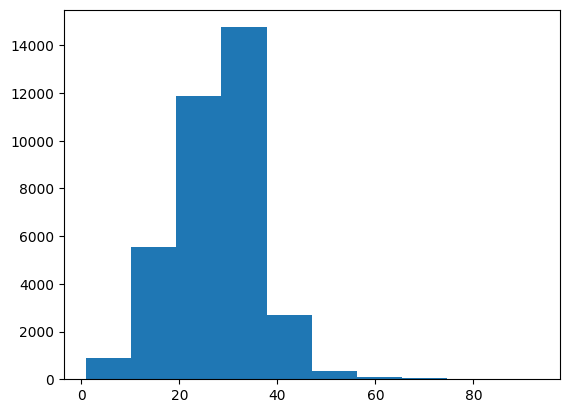

In [95]:
from matplotlib import pyplot as plt
plt.hist(df2.head(1000000).post_id.value_counts())

In [102]:
get(f"/{index_id}", dict()).json()

{'index_id': 'index_ac07f8845e914efbb9ddc07676d0fda6',
 'name': 'hacker_news_comments_v7',
 'state': 'ready'}

In [100]:
tmp = df2.head(1000000).to_dict("records")
for batch in tqdm(chunked(tmp[2400*200:], 200)):
    res = post(f"/{index_id}/doc", dict(docs=batch))
    print(res.status_code)
commit(index_id)
res = post(f"/{index_id}/train", dict(K=512, doc_hierarchy=["post_id"], ))
print(res.content)

1it [00:01,  1.69s/it]

200


2it [00:03,  1.68s/it]

200


3it [00:05,  1.78s/it]

200


4it [00:06,  1.76s/it]

200


5it [00:10,  2.32s/it]

200


6it [00:13,  2.70s/it]

200


7it [00:17,  2.92s/it]

200


8it [00:20,  2.99s/it]

200


9it [00:23,  3.01s/it]

200


10it [00:26,  3.07s/it]

200


11it [00:29,  3.09s/it]

200


12it [00:32,  3.16s/it]

200


13it [00:36,  3.16s/it]

200


14it [00:39,  3.22s/it]

200


15it [00:42,  3.20s/it]

200


16it [00:46,  3.26s/it]

200


17it [00:49,  3.19s/it]

200


18it [00:52,  3.17s/it]

200


19it [00:55,  3.14s/it]

200


20it [00:58,  3.18s/it]

200


21it [01:01,  3.18s/it]

200


22it [01:04,  3.14s/it]

200


23it [01:08,  3.21s/it]

200


24it [01:11,  3.25s/it]

200


25it [01:14,  3.24s/it]

200


26it [01:17,  3.21s/it]

200


27it [01:21,  3.23s/it]

200


28it [01:24,  3.29s/it]

200


29it [01:27,  3.31s/it]

200


30it [01:31,  3.31s/it]

200


31it [01:34,  3.26s/it]

200


32it [01:37,  3.25s/it]

200


33it [01:40,  3.26s/it]

200


34it [01:44,  3.24s/it]

200


35it [01:47,  3.34s/it]

200


36it [01:50,  3.25s/it]

200


37it [01:53,  3.24s/it]

200


38it [01:57,  3.23s/it]

200


39it [02:00,  3.18s/it]

200


40it [02:03,  3.21s/it]

200


41it [02:06,  3.19s/it]

200


42it [02:09,  3.14s/it]

200


43it [02:12,  3.13s/it]

200


44it [02:16,  3.28s/it]

200


45it [02:19,  3.27s/it]

200


46it [02:22,  3.31s/it]

200


47it [02:26,  3.31s/it]

200


48it [02:29,  3.29s/it]

200


49it [02:32,  3.24s/it]

200


50it [02:35,  3.24s/it]

200


51it [02:38,  3.17s/it]

200


52it [02:42,  3.20s/it]

200


53it [02:45,  3.20s/it]

200


54it [02:48,  3.22s/it]

200


55it [02:51,  3.17s/it]

200


56it [02:54,  3.19s/it]

200


57it [02:58,  3.16s/it]

200


58it [03:01,  3.20s/it]

200


59it [03:04,  3.22s/it]

200


60it [03:08,  3.28s/it]

200


61it [03:11,  3.26s/it]

200


62it [03:14,  3.39s/it]

200


63it [03:18,  3.33s/it]

200


64it [03:21,  3.34s/it]

200


65it [03:24,  3.32s/it]

200


66it [03:27,  3.27s/it]

200


67it [03:31,  3.27s/it]

200


68it [03:34,  3.38s/it]

200


69it [03:38,  3.37s/it]

200


70it [03:41,  3.37s/it]

200


71it [03:44,  3.29s/it]

200


72it [03:47,  3.24s/it]

200


73it [03:50,  3.17s/it]

200


74it [03:53,  3.15s/it]

200


75it [03:57,  3.15s/it]

200


76it [04:00,  3.14s/it]

200


77it [04:03,  3.11s/it]

200


78it [04:06,  3.16s/it]

200


79it [04:09,  3.25s/it]

200


80it [04:13,  3.21s/it]

200


81it [04:16,  3.20s/it]

200


82it [04:19,  3.30s/it]

200


83it [04:22,  3.26s/it]

200


84it [04:26,  3.23s/it]

200


85it [04:29,  3.30s/it]

200


86it [04:32,  3.32s/it]

200


87it [04:36,  3.32s/it]

200


88it [04:39,  3.30s/it]

200


89it [04:42,  3.32s/it]

200


90it [04:46,  3.30s/it]

200


91it [04:49,  3.29s/it]

200


92it [04:52,  3.24s/it]

200


93it [04:55,  3.20s/it]

200


94it [04:58,  3.21s/it]

200


95it [05:02,  3.23s/it]

200


96it [05:05,  3.33s/it]

200


97it [05:08,  3.33s/it]

200


98it [05:12,  3.34s/it]

200


99it [05:15,  3.39s/it]

200


100it [05:19,  3.39s/it]

200


101it [05:22,  3.30s/it]

200


102it [05:25,  3.31s/it]

200


103it [05:29,  3.37s/it]

200


104it [05:32,  3.34s/it]

200


105it [05:36,  3.45s/it]

200


106it [05:39,  3.43s/it]

200


107it [05:42,  3.39s/it]

200


108it [05:46,  3.38s/it]

200


109it [05:49,  3.30s/it]

200


110it [05:52,  3.26s/it]

200


111it [05:55,  3.28s/it]

200


112it [05:59,  3.32s/it]

200


113it [06:02,  3.29s/it]

200


114it [06:05,  3.31s/it]

200


115it [06:08,  3.28s/it]

200


116it [06:12,  3.33s/it]

200


117it [06:15,  3.34s/it]

200


118it [06:19,  3.41s/it]

200


119it [06:22,  3.34s/it]

200


120it [06:25,  3.34s/it]

200


121it [06:29,  3.29s/it]

200


122it [06:32,  3.36s/it]

200


123it [06:36,  3.38s/it]

200


124it [06:39,  3.32s/it]

200


125it [06:42,  3.32s/it]

200


126it [06:45,  3.31s/it]

200


127it [06:49,  3.40s/it]

200


128it [06:52,  3.35s/it]

200


129it [06:56,  3.35s/it]

200


130it [06:59,  3.41s/it]

200


131it [07:02,  3.41s/it]

200


132it [07:06,  3.39s/it]

200


133it [07:09,  3.40s/it]

200


134it [07:12,  3.32s/it]

200


135it [07:16,  3.37s/it]

200


136it [07:19,  3.35s/it]

200


137it [07:22,  3.28s/it]

200


138it [07:26,  3.34s/it]

200


139it [07:29,  3.32s/it]

200


140it [07:32,  3.31s/it]

200


141it [07:36,  3.31s/it]

200


142it [07:39,  3.34s/it]

200


143it [07:42,  3.31s/it]

200


144it [07:46,  3.38s/it]

200


145it [07:49,  3.36s/it]

200


146it [07:52,  3.32s/it]

200


147it [07:56,  3.35s/it]

200


148it [07:59,  3.27s/it]

200


149it [08:02,  3.26s/it]

200


150it [08:06,  3.40s/it]

200


151it [08:09,  3.39s/it]

200


152it [08:12,  3.35s/it]

200


153it [08:16,  3.43s/it]

200


154it [08:19,  3.32s/it]

200


155it [08:23,  3.38s/it]

200


156it [08:26,  3.39s/it]

200


157it [08:29,  3.36s/it]

200


158it [08:33,  3.38s/it]

200


159it [08:36,  3.35s/it]

200


160it [08:40,  3.38s/it]

200


161it [08:43,  3.34s/it]

200


162it [08:46,  3.32s/it]

200


163it [08:49,  3.33s/it]

200


164it [08:53,  3.37s/it]

200


165it [08:56,  3.36s/it]

200


166it [09:00,  3.40s/it]

200


167it [09:03,  3.41s/it]

200


168it [09:06,  3.36s/it]

200


169it [09:10,  3.45s/it]

200


170it [09:13,  3.40s/it]

200


171it [09:16,  3.33s/it]

200


172it [09:20,  3.38s/it]

200


173it [09:23,  3.36s/it]

200


174it [09:26,  3.32s/it]

200


175it [09:30,  3.37s/it]

200


176it [09:33,  3.34s/it]

200


177it [09:37,  3.42s/it]

200


178it [09:40,  3.37s/it]

200


179it [09:44,  3.41s/it]

200


180it [09:47,  3.37s/it]

200


181it [09:50,  3.43s/it]

200


182it [09:54,  3.44s/it]

200


183it [09:57,  3.45s/it]

200


184it [10:01,  3.42s/it]

200


185it [10:04,  3.45s/it]

200


186it [10:08,  3.43s/it]

200


187it [10:11,  3.40s/it]

200


188it [10:14,  3.38s/it]

200


189it [10:18,  3.38s/it]

200


190it [10:21,  3.46s/it]

200


191it [10:25,  3.50s/it]

200


192it [10:28,  3.46s/it]

200


193it [10:31,  3.36s/it]

200


194it [10:35,  3.37s/it]

200


195it [10:38,  3.34s/it]

200


196it [10:41,  3.35s/it]

200


197it [10:45,  3.42s/it]

200


198it [10:49,  3.43s/it]

200


199it [10:52,  3.40s/it]

200


200it [10:55,  3.46s/it]

200


201it [10:59,  3.43s/it]

200


202it [11:02,  3.50s/it]

200


203it [11:06,  3.54s/it]

200


204it [11:10,  3.55s/it]

200


205it [11:13,  3.59s/it]

200


206it [11:17,  3.49s/it]

200


207it [11:20,  3.49s/it]

200


208it [11:24,  3.54s/it]

200


209it [11:27,  3.49s/it]

200


210it [11:31,  3.51s/it]

200


211it [11:34,  3.45s/it]

200


212it [11:37,  3.36s/it]

200


213it [11:41,  3.42s/it]

200


214it [11:44,  3.34s/it]

200


215it [11:47,  3.33s/it]

200


216it [11:50,  3.33s/it]

200


217it [11:54,  3.40s/it]

200


218it [11:58,  3.44s/it]

200


219it [12:01,  3.48s/it]

200


220it [12:04,  3.39s/it]

200


221it [12:08,  3.41s/it]

200


222it [12:11,  3.49s/it]

200


223it [12:15,  3.47s/it]

200


224it [12:18,  3.45s/it]

200


225it [12:22,  3.48s/it]

200


226it [12:26,  3.55s/it]

200


227it [12:29,  3.53s/it]

200


228it [12:33,  3.52s/it]

200


229it [12:36,  3.54s/it]

200


230it [12:40,  3.52s/it]

200


231it [12:43,  3.55s/it]

200


232it [12:46,  3.47s/it]

200


233it [12:50,  3.45s/it]

200


234it [12:53,  3.48s/it]

200


235it [12:57,  3.49s/it]

200


236it [13:00,  3.41s/it]

200


237it [13:04,  3.47s/it]

200


238it [13:07,  3.50s/it]

200


239it [13:11,  3.49s/it]

200


240it [13:14,  3.54s/it]

200


241it [13:18,  3.56s/it]

200


242it [13:22,  3.54s/it]

200


243it [13:25,  3.52s/it]

200


244it [13:29,  3.55s/it]

200


245it [13:32,  3.54s/it]

200


246it [13:36,  3.50s/it]

200


247it [13:39,  3.49s/it]

200


248it [13:43,  3.55s/it]

200


249it [13:46,  3.53s/it]

200


250it [13:50,  3.50s/it]

200


251it [13:53,  3.52s/it]

200


252it [13:57,  3.53s/it]

200


253it [14:00,  3.52s/it]

200


254it [14:04,  3.43s/it]

200


255it [14:07,  3.43s/it]

200


256it [14:11,  3.52s/it]

200


257it [14:14,  3.47s/it]

200


258it [14:18,  3.57s/it]

200


259it [14:21,  3.52s/it]

200


260it [14:25,  3.47s/it]

200


261it [14:28,  3.59s/it]

200


262it [14:32,  3.51s/it]

200


263it [14:35,  3.52s/it]

200


264it [14:39,  3.63s/it]

200


265it [14:43,  3.57s/it]

200


266it [14:46,  3.53s/it]

200


267it [14:50,  3.53s/it]

200


268it [14:53,  3.52s/it]

200


269it [14:57,  3.63s/it]

200


270it [15:00,  3.59s/it]

200


271it [15:04,  3.62s/it]

200


272it [15:08,  3.61s/it]

200


273it [15:11,  3.62s/it]

200


274it [15:15,  3.62s/it]

200


275it [15:19,  3.67s/it]

200


276it [15:22,  3.62s/it]

200


277it [15:26,  3.63s/it]

200


278it [15:29,  3.58s/it]

200


279it [15:33,  3.66s/it]

200


280it [15:37,  3.61s/it]

200


281it [15:40,  3.51s/it]

200


282it [15:43,  3.47s/it]

200


283it [15:47,  3.42s/it]

200


284it [15:50,  3.50s/it]

200


285it [15:54,  3.51s/it]

200


286it [15:58,  3.56s/it]

200


287it [16:01,  3.54s/it]

200


288it [16:05,  3.51s/it]

200


289it [16:08,  3.57s/it]

200


290it [16:12,  3.49s/it]

200


291it [16:16,  3.64s/it]

200


292it [16:19,  3.59s/it]

200


293it [16:23,  3.61s/it]

200


294it [16:26,  3.58s/it]

200


295it [16:30,  3.56s/it]

200


296it [16:33,  3.57s/it]

200


297it [16:37,  3.53s/it]

200


298it [16:40,  3.55s/it]

200


299it [16:44,  3.51s/it]

200


300it [16:47,  3.52s/it]

200


301it [16:51,  3.51s/it]

200


302it [16:54,  3.45s/it]

200


303it [16:58,  3.47s/it]

200


304it [17:01,  3.48s/it]

200


305it [17:05,  3.47s/it]

200


306it [17:08,  3.52s/it]

200


307it [17:11,  3.46s/it]

200


308it [17:15,  3.42s/it]

200


309it [17:18,  3.44s/it]

200


310it [17:22,  3.40s/it]

200


311it [17:25,  3.41s/it]

200


312it [17:29,  3.45s/it]

200


313it [17:32,  3.50s/it]

200


314it [17:36,  3.57s/it]

200


315it [17:40,  3.60s/it]

200


316it [17:43,  3.58s/it]

200


317it [17:47,  3.58s/it]

200


318it [17:50,  3.52s/it]

200


319it [17:53,  3.47s/it]

200


320it [17:57,  3.57s/it]

200


321it [18:01,  3.51s/it]

200


322it [18:04,  3.49s/it]

200


323it [18:08,  3.49s/it]

200


324it [18:11,  3.50s/it]

200


325it [18:15,  3.50s/it]

200


326it [18:18,  3.55s/it]

200


327it [18:22,  3.56s/it]

200


328it [18:25,  3.57s/it]

200


329it [18:29,  3.53s/it]

200


330it [18:32,  3.52s/it]

200


331it [18:36,  3.44s/it]

200


332it [18:39,  3.44s/it]

200


333it [18:43,  3.53s/it]

200


334it [18:46,  3.52s/it]

200


335it [18:50,  3.60s/it]

200


336it [18:53,  3.53s/it]

200


337it [18:57,  3.48s/it]

200


338it [19:01,  3.54s/it]

200


339it [19:04,  3.52s/it]

200


340it [19:08,  3.58s/it]

200


341it [19:11,  3.55s/it]

200


342it [19:15,  3.60s/it]

200


343it [19:19,  3.75s/it]

200


344it [19:23,  3.71s/it]

200


345it [19:26,  3.72s/it]

200


346it [19:30,  3.72s/it]

200


347it [19:34,  3.71s/it]

200


348it [19:37,  3.61s/it]

200


349it [19:41,  3.64s/it]

200


350it [19:45,  3.66s/it]

200


351it [19:48,  3.58s/it]

200


352it [19:52,  3.70s/it]

200


353it [19:55,  3.66s/it]

200


354it [19:59,  3.58s/it]

200


355it [20:03,  3.67s/it]

200


356it [20:06,  3.65s/it]

200


357it [20:10,  3.59s/it]

200


358it [20:13,  3.57s/it]

200


359it [20:17,  3.57s/it]

200


360it [20:20,  3.56s/it]

200


361it [20:24,  3.57s/it]

200


362it [20:28,  3.54s/it]

200


363it [20:31,  3.66s/it]

200


364it [20:35,  3.57s/it]

200


365it [20:38,  3.57s/it]

200


366it [20:42,  3.53s/it]

200


367it [20:45,  3.48s/it]

200


368it [20:49,  3.49s/it]

200


369it [20:52,  3.43s/it]

200


370it [20:56,  3.52s/it]

200


371it [20:59,  3.53s/it]

200


372it [21:03,  3.47s/it]

200


373it [21:06,  3.46s/it]

200


374it [21:09,  3.46s/it]

200


375it [21:13,  3.54s/it]

200


376it [21:17,  3.52s/it]

200


377it [21:20,  3.48s/it]

200


378it [21:23,  3.42s/it]

200


379it [21:27,  3.43s/it]

200


380it [21:31,  3.57s/it]

200


381it [21:34,  3.60s/it]

200


382it [21:38,  3.59s/it]

200


383it [21:42,  3.61s/it]

200


384it [21:45,  3.57s/it]

200


385it [21:49,  3.54s/it]

200


386it [21:52,  3.51s/it]

200


387it [21:56,  3.55s/it]

200


388it [21:59,  3.57s/it]

200


389it [22:03,  3.60s/it]

200


390it [22:06,  3.56s/it]

200


391it [22:10,  3.51s/it]

200


392it [22:13,  3.53s/it]

200


393it [22:17,  3.60s/it]

200


394it [22:21,  3.58s/it]

200


395it [22:24,  3.58s/it]

200


396it [22:27,  3.47s/it]

200


397it [22:31,  3.54s/it]

200


398it [22:35,  3.54s/it]

200


399it [22:38,  3.52s/it]

200


400it [22:42,  3.52s/it]

200


401it [22:45,  3.54s/it]

200


402it [22:49,  3.50s/it]

200


403it [22:52,  3.51s/it]

200


404it [22:56,  3.46s/it]

200


405it [22:59,  3.49s/it]

200


406it [23:03,  3.60s/it]

200


407it [23:07,  3.63s/it]

200


408it [23:11,  3.70s/it]

200


409it [23:14,  3.70s/it]

200


410it [23:18,  3.61s/it]

200


411it [23:21,  3.53s/it]

200


412it [23:25,  3.59s/it]

200


413it [23:28,  3.56s/it]

200


414it [23:32,  3.57s/it]

200


415it [23:35,  3.50s/it]

200


416it [23:39,  3.56s/it]

200


417it [23:42,  3.51s/it]

200


418it [23:46,  3.56s/it]

200


419it [23:50,  3.61s/it]

200


420it [23:53,  3.52s/it]

200


421it [23:56,  3.51s/it]

200


422it [24:00,  3.50s/it]

200


423it [24:03,  3.49s/it]

200


424it [24:07,  3.50s/it]

200


425it [24:10,  3.50s/it]

200


426it [24:14,  3.49s/it]

200


427it [24:18,  3.56s/it]

200


428it [24:21,  3.51s/it]

200


429it [24:24,  3.50s/it]

200


430it [24:28,  3.54s/it]

200


431it [24:31,  3.42s/it]

200


432it [24:35,  3.53s/it]

200


433it [24:39,  3.60s/it]

200


434it [24:43,  3.65s/it]

200


435it [24:46,  3.68s/it]

200


436it [24:50,  3.69s/it]

200


437it [24:54,  3.69s/it]

200


438it [24:57,  3.66s/it]

200


439it [25:01,  3.61s/it]

200


440it [25:04,  3.64s/it]

200


441it [25:08,  3.57s/it]

200


442it [25:11,  3.57s/it]

200


443it [25:15,  3.57s/it]

200


444it [25:19,  3.62s/it]

200


445it [25:22,  3.60s/it]

200


446it [25:26,  3.60s/it]

200


447it [25:29,  3.57s/it]

200


448it [25:33,  3.57s/it]

200


449it [25:36,  3.49s/it]

200


450it [25:40,  3.53s/it]

200


451it [25:44,  3.60s/it]

200


452it [25:47,  3.62s/it]

200


453it [25:51,  3.60s/it]

200


454it [25:54,  3.60s/it]

200


455it [25:58,  3.52s/it]

200


456it [26:01,  3.50s/it]

200


457it [26:05,  3.53s/it]

200


458it [26:08,  3.56s/it]

200


459it [26:12,  3.53s/it]

200


460it [26:16,  3.58s/it]

200


461it [26:20,  3.69s/it]

200


462it [26:23,  3.58s/it]

200


463it [26:26,  3.48s/it]

200


464it [26:30,  3.59s/it]

200


465it [26:34,  3.62s/it]

200


466it [26:37,  3.55s/it]

200


467it [26:41,  3.53s/it]

200


468it [26:45,  3.68s/it]

200


469it [26:48,  3.73s/it]

200


470it [26:52,  3.61s/it]

200


471it [26:56,  3.65s/it]

200


472it [26:59,  3.58s/it]

200


473it [27:03,  3.58s/it]

200


474it [27:06,  3.57s/it]

200


475it [27:09,  3.53s/it]

200


476it [27:13,  3.51s/it]

200


477it [27:16,  3.48s/it]

200


478it [27:20,  3.47s/it]

200


479it [27:23,  3.45s/it]

200


480it [27:27,  3.57s/it]

200


481it [27:31,  3.55s/it]

200


482it [27:34,  3.52s/it]

200


483it [27:38,  3.58s/it]

200


484it [27:42,  3.65s/it]

200


485it [27:45,  3.53s/it]

200


486it [27:48,  3.53s/it]

200


487it [27:52,  3.60s/it]

200


488it [27:56,  3.63s/it]

200


489it [28:00,  3.71s/it]

200


490it [28:03,  3.66s/it]

200


491it [28:07,  3.56s/it]

200


492it [28:10,  3.60s/it]

200


493it [28:14,  3.53s/it]

200


494it [28:17,  3.55s/it]

200


495it [28:21,  3.55s/it]

200


496it [28:24,  3.54s/it]

200


497it [28:28,  3.57s/it]

200


498it [28:32,  3.61s/it]

200


499it [28:35,  3.60s/it]

200


500it [28:39,  3.60s/it]

200


501it [28:43,  3.72s/it]

200


502it [28:47,  3.75s/it]

200


503it [28:50,  3.65s/it]

200


504it [28:54,  3.69s/it]

200


505it [28:57,  3.65s/it]

200


506it [29:01,  3.64s/it]

200


507it [29:05,  3.66s/it]

200


508it [29:08,  3.65s/it]

200


509it [29:12,  3.69s/it]

200


510it [29:16,  3.69s/it]

200


511it [29:19,  3.69s/it]

200


512it [29:23,  3.75s/it]

200


513it [29:27,  3.70s/it]

200


514it [29:30,  3.62s/it]

200


515it [29:34,  3.69s/it]

200


516it [29:38,  3.73s/it]

200


517it [29:42,  3.78s/it]

200


518it [29:46,  3.74s/it]

200


519it [29:49,  3.70s/it]

200


520it [29:53,  3.68s/it]

200


521it [29:56,  3.63s/it]

200


522it [30:00,  3.61s/it]

200


523it [30:04,  3.61s/it]

200


524it [30:07,  3.60s/it]

200


525it [30:11,  3.63s/it]

200


526it [30:14,  3.62s/it]

200


527it [30:18,  3.66s/it]

200


528it [30:22,  3.70s/it]

200


529it [30:25,  3.63s/it]

200


530it [30:29,  3.59s/it]

200


531it [30:32,  3.59s/it]

200


532it [30:36,  3.65s/it]

200


533it [30:40,  3.68s/it]

200


534it [30:44,  3.69s/it]

200


535it [30:47,  3.69s/it]

200


536it [30:51,  3.69s/it]

200


537it [30:55,  3.73s/it]

200


538it [30:59,  3.71s/it]

200


539it [31:02,  3.73s/it]

200


540it [31:06,  3.65s/it]

200


541it [31:09,  3.60s/it]

200


542it [31:13,  3.66s/it]

200


543it [31:17,  3.73s/it]

200


544it [31:21,  3.72s/it]

200


545it [31:25,  3.77s/it]

200


546it [31:29,  3.84s/it]

200


547it [31:32,  3.82s/it]

200


548it [31:36,  3.77s/it]

200


549it [31:40,  3.73s/it]

200


550it [31:43,  3.68s/it]

200


551it [31:47,  3.68s/it]

200


552it [31:50,  3.65s/it]

200


553it [31:54,  3.60s/it]

200


554it [31:57,  3.57s/it]

200


555it [32:01,  3.60s/it]

200


556it [32:05,  3.69s/it]

200


557it [32:08,  3.56s/it]

200


558it [32:12,  3.57s/it]

200


559it [32:16,  3.61s/it]

200


560it [32:19,  3.66s/it]

200


561it [32:23,  3.73s/it]

200


562it [32:27,  3.81s/it]

200


563it [32:31,  3.74s/it]

200


564it [32:35,  3.76s/it]

200


565it [32:38,  3.73s/it]

200


566it [32:42,  3.72s/it]

200


567it [32:46,  3.77s/it]

200


568it [32:50,  3.72s/it]

200


569it [32:53,  3.71s/it]

200


570it [32:57,  3.70s/it]

200


571it [33:00,  3.64s/it]

200


572it [33:04,  3.68s/it]

200


573it [33:08,  3.71s/it]

200


574it [33:11,  3.64s/it]

200


575it [33:16,  3.78s/it]

200


576it [33:19,  3.72s/it]

200


577it [33:23,  3.71s/it]

200


578it [33:27,  3.80s/it]

200


579it [33:31,  3.78s/it]

200


580it [33:34,  3.70s/it]

200


581it [33:38,  3.82s/it]

200


582it [33:42,  3.72s/it]

200


583it [33:45,  3.68s/it]

200


584it [33:49,  3.65s/it]

200


585it [33:52,  3.66s/it]

200


586it [33:56,  3.70s/it]

200


587it [34:00,  3.85s/it]

200


588it [34:04,  3.83s/it]

200


589it [34:08,  3.73s/it]

200


590it [34:11,  3.68s/it]

200


591it [34:15,  3.68s/it]

200


592it [34:19,  3.66s/it]

200


593it [34:22,  3.64s/it]

200


594it [34:26,  3.74s/it]

200


595it [34:30,  3.70s/it]

200


596it [34:33,  3.66s/it]

200


597it [34:37,  3.64s/it]

200


598it [34:40,  3.61s/it]

200


599it [34:44,  3.67s/it]

200


600it [34:48,  3.71s/it]

200


601it [34:52,  3.67s/it]

200


602it [34:56,  3.74s/it]

200


603it [34:59,  3.76s/it]

200


604it [35:03,  3.70s/it]

200


605it [35:07,  3.76s/it]

200


606it [35:10,  3.72s/it]

200


607it [35:14,  3.70s/it]

200


608it [35:18,  3.66s/it]

200


609it [35:21,  3.67s/it]

200


610it [35:25,  3.64s/it]

200


611it [35:29,  3.72s/it]

200


612it [35:33,  3.79s/it]

200


613it [35:37,  3.80s/it]

200


614it [35:40,  3.74s/it]

200


615it [35:44,  3.81s/it]

200


616it [35:48,  3.80s/it]

200


617it [35:52,  3.77s/it]

200


618it [35:55,  3.77s/it]

200


619it [35:59,  3.81s/it]

200


620it [36:03,  3.74s/it]

200


621it [36:07,  3.85s/it]

200


622it [36:11,  3.80s/it]

200


623it [36:14,  3.72s/it]

200


624it [36:18,  3.77s/it]

200


625it [36:22,  3.73s/it]

200


626it [36:25,  3.72s/it]

200


627it [36:29,  3.80s/it]

200


628it [36:33,  3.74s/it]

200


629it [36:37,  3.81s/it]

200


630it [36:41,  3.81s/it]

200


631it [36:44,  3.74s/it]

200


632it [36:48,  3.74s/it]

200


633it [36:52,  3.77s/it]

200


634it [36:56,  3.78s/it]

200


635it [37:00,  3.78s/it]

200


636it [37:03,  3.75s/it]

200


637it [37:07,  3.76s/it]

200


638it [37:10,  3.67s/it]

200


639it [37:14,  3.72s/it]

200


640it [37:18,  3.68s/it]

200


641it [37:22,  3.68s/it]

200


642it [37:25,  3.68s/it]

200


643it [37:29,  3.71s/it]

200


644it [37:33,  3.70s/it]

200


645it [37:37,  3.76s/it]

200


646it [37:40,  3.79s/it]

200


647it [37:44,  3.74s/it]

200


648it [37:48,  3.72s/it]

200


649it [37:52,  3.77s/it]

200


650it [37:55,  3.78s/it]

200


651it [37:59,  3.77s/it]

200


652it [38:03,  3.76s/it]

200


653it [38:07,  3.71s/it]

200


654it [38:10,  3.76s/it]

200


655it [38:14,  3.77s/it]

200


656it [38:18,  3.71s/it]

200


657it [38:22,  3.83s/it]

200


658it [38:26,  3.76s/it]

200


659it [38:29,  3.82s/it]

200


660it [38:33,  3.78s/it]

200


661it [38:37,  3.85s/it]

200


662it [38:41,  3.86s/it]

200


663it [38:45,  3.96s/it]

200


664it [38:50,  4.09s/it]

200


665it [38:53,  3.97s/it]

200


666it [38:57,  3.86s/it]

200


667it [39:01,  3.77s/it]

200


668it [39:05,  3.84s/it]

200


669it [39:08,  3.86s/it]

200


670it [39:12,  3.77s/it]

200


671it [39:16,  3.72s/it]

200


672it [39:20,  3.83s/it]

200


673it [39:23,  3.76s/it]

200


674it [39:27,  3.74s/it]

200


675it [39:31,  3.80s/it]

200


676it [39:35,  3.85s/it]

200


677it [39:39,  3.80s/it]

200


678it [39:42,  3.82s/it]

200


679it [39:46,  3.81s/it]

200


680it [39:50,  3.87s/it]

200


681it [39:54,  3.87s/it]

200


682it [39:58,  3.91s/it]

200


683it [40:02,  3.90s/it]

200


684it [40:06,  3.85s/it]

200


685it [40:09,  3.79s/it]

200


686it [40:13,  3.76s/it]

200


687it [40:17,  3.83s/it]

200


688it [40:21,  3.80s/it]

200


689it [40:24,  3.69s/it]

200


690it [40:28,  3.66s/it]

200


691it [40:31,  3.67s/it]

200


692it [40:35,  3.73s/it]

200


693it [40:39,  3.69s/it]

200


694it [40:43,  3.72s/it]

200


695it [40:47,  3.80s/it]

200


696it [40:50,  3.78s/it]

200


697it [40:54,  3.77s/it]

200


698it [40:58,  3.75s/it]

200


699it [41:01,  3.69s/it]

200


700it [41:05,  3.73s/it]

200


701it [41:09,  3.84s/it]

200


702it [41:13,  3.85s/it]

200


703it [41:17,  3.84s/it]

200


704it [41:21,  3.85s/it]

200


705it [41:25,  3.89s/it]

200


706it [41:29,  3.92s/it]

200


707it [41:33,  3.91s/it]

200


708it [41:37,  3.88s/it]

200


709it [41:40,  3.82s/it]

200


710it [41:44,  3.84s/it]

200


711it [41:48,  3.82s/it]

200


712it [41:52,  3.81s/it]

200


713it [41:56,  3.80s/it]

200


714it [42:00,  3.89s/it]

200


715it [42:04,  3.89s/it]

200


716it [42:07,  3.89s/it]

200


717it [42:11,  3.85s/it]

200


718it [42:15,  3.72s/it]

200


719it [42:18,  3.75s/it]

200


720it [42:22,  3.81s/it]

200


721it [42:26,  3.84s/it]

200


722it [42:30,  3.78s/it]

200


723it [42:34,  3.79s/it]

200


724it [42:37,  3.79s/it]

200


725it [42:41,  3.76s/it]

200


726it [42:45,  3.77s/it]

200


727it [42:48,  3.69s/it]

200


728it [42:52,  3.75s/it]

200


729it [42:56,  3.82s/it]

200


730it [43:00,  3.81s/it]

200


731it [43:04,  3.80s/it]

200


732it [43:08,  3.74s/it]

200


733it [43:11,  3.81s/it]

200


734it [43:15,  3.73s/it]

200


735it [43:19,  3.76s/it]

200


736it [43:22,  3.71s/it]

200


737it [43:26,  3.79s/it]

200


738it [43:30,  3.79s/it]

200


739it [43:34,  3.82s/it]

200


740it [43:38,  3.87s/it]

200


741it [43:42,  3.88s/it]

200


742it [43:46,  3.88s/it]

200


743it [43:50,  3.82s/it]

200


744it [43:53,  3.78s/it]

200


745it [43:57,  3.81s/it]

200


746it [44:01,  3.70s/it]

200


747it [44:05,  3.77s/it]

200


748it [44:09,  3.87s/it]

200


749it [44:13,  3.88s/it]

200


750it [44:17,  3.91s/it]

200


751it [44:21,  3.94s/it]

200


752it [44:24,  3.93s/it]

200


753it [44:28,  3.88s/it]

200


754it [44:32,  3.88s/it]

200


755it [44:36,  3.92s/it]

200


756it [44:40,  3.90s/it]

200


757it [44:44,  3.91s/it]

200


758it [44:48,  3.93s/it]

200


759it [44:52,  3.92s/it]

200


760it [44:55,  3.85s/it]

200


761it [45:00,  3.92s/it]

200


762it [45:04,  3.94s/it]

200


763it [45:07,  3.90s/it]

200


764it [45:11,  3.83s/it]

200


765it [45:15,  3.79s/it]

200


766it [45:19,  3.82s/it]

200


767it [45:22,  3.81s/it]

200


768it [45:26,  3.86s/it]

200


769it [45:30,  3.78s/it]

200


770it [45:34,  3.79s/it]

200


771it [45:38,  3.79s/it]

200


772it [45:41,  3.82s/it]

200


773it [45:46,  3.90s/it]

200


774it [45:50,  3.96s/it]

200


775it [45:54,  4.00s/it]

200


776it [45:58,  4.00s/it]

200


777it [46:02,  3.97s/it]

200


778it [46:05,  3.87s/it]

200


779it [46:09,  3.89s/it]

200


780it [46:13,  3.95s/it]

200


781it [46:17,  3.90s/it]

200


782it [46:21,  3.92s/it]

200


783it [46:25,  3.86s/it]

200


784it [46:29,  3.86s/it]

200


785it [46:33,  3.88s/it]

200


786it [46:36,  3.84s/it]

200


787it [46:40,  3.92s/it]

200


788it [46:44,  3.95s/it]

200


789it [46:48,  3.90s/it]

200


790it [46:52,  3.78s/it]

200


791it [46:56,  3.84s/it]

200


792it [47:00,  3.88s/it]

200


793it [47:04,  3.92s/it]

200


794it [47:07,  3.88s/it]

200


795it [47:11,  3.92s/it]

200


796it [47:15,  3.94s/it]

200


797it [47:19,  3.92s/it]

200


798it [47:23,  3.91s/it]

200


799it [47:27,  3.94s/it]

200


800it [47:31,  3.89s/it]

200


801it [47:35,  3.86s/it]

200


802it [47:38,  3.79s/it]

200


803it [47:42,  3.75s/it]

200


804it [47:46,  3.76s/it]

200


805it [47:50,  3.83s/it]

200


806it [47:54,  3.85s/it]

200


807it [47:58,  3.89s/it]

200


808it [48:02,  3.89s/it]

200


809it [48:06,  3.95s/it]

200


810it [48:10,  3.94s/it]

200


811it [48:14,  4.05s/it]

200


812it [48:18,  4.03s/it]

200


813it [48:22,  3.93s/it]

200


814it [48:25,  3.88s/it]

200


815it [48:29,  3.95s/it]

200


816it [48:33,  3.96s/it]

200


817it [48:37,  3.93s/it]

200


818it [48:41,  3.90s/it]

200


819it [48:45,  3.93s/it]

200


820it [48:49,  3.92s/it]

200


821it [48:53,  3.85s/it]

200


822it [48:57,  3.89s/it]

200


823it [49:01,  3.88s/it]

200


824it [49:05,  3.92s/it]

200


825it [49:08,  3.83s/it]

200


826it [49:12,  3.96s/it]

200


827it [49:16,  3.91s/it]

200


828it [49:20,  3.84s/it]

200


829it [49:24,  3.89s/it]

200


830it [49:28,  3.92s/it]

200


831it [49:32,  3.98s/it]

200


832it [49:36,  3.95s/it]

200


833it [49:40,  3.94s/it]

200


834it [49:44,  3.98s/it]

200


835it [49:48,  3.89s/it]

200


836it [49:51,  3.83s/it]

200


837it [49:55,  3.82s/it]

200


838it [49:59,  3.84s/it]

200


839it [50:03,  3.88s/it]

200


840it [50:07,  3.89s/it]

200


841it [50:11,  3.92s/it]

200


842it [50:15,  3.97s/it]

200


843it [50:19,  3.89s/it]

200


844it [50:23,  3.92s/it]

200


845it [50:27,  4.00s/it]

200


846it [50:31,  3.94s/it]

200


847it [50:34,  3.92s/it]

200


848it [50:38,  3.85s/it]

200


849it [50:42,  3.84s/it]

200


850it [50:46,  3.83s/it]

200


851it [50:50,  3.80s/it]

200


852it [50:53,  3.77s/it]

200


853it [50:57,  3.72s/it]

200


854it [51:01,  3.76s/it]

200


855it [51:04,  3.75s/it]

200


856it [51:09,  3.88s/it]

200


857it [51:12,  3.88s/it]

200


858it [51:17,  3.95s/it]

200


859it [51:20,  3.90s/it]

200


860it [51:24,  3.90s/it]

200


861it [51:28,  3.92s/it]

200


862it [51:32,  3.89s/it]

200


863it [51:36,  3.89s/it]

200


864it [51:40,  3.96s/it]

200


865it [51:44,  3.90s/it]

200


866it [51:48,  3.87s/it]

200


867it [51:51,  3.84s/it]

200


868it [51:55,  3.86s/it]

200


869it [51:59,  3.83s/it]

200


870it [52:03,  3.85s/it]

200


871it [52:07,  3.80s/it]

200


872it [52:10,  3.77s/it]

200


873it [52:14,  3.75s/it]

200


874it [52:18,  3.79s/it]

200


875it [52:22,  3.79s/it]

200


876it [52:26,  3.90s/it]

200


877it [52:30,  3.83s/it]

200


878it [52:34,  3.90s/it]

200


879it [52:37,  3.89s/it]

200


880it [52:41,  3.92s/it]

200


881it [52:46,  3.96s/it]

200


882it [52:49,  3.91s/it]

200


883it [52:53,  3.91s/it]

200


884it [52:57,  3.88s/it]

200


885it [53:01,  3.87s/it]

200


886it [53:05,  3.86s/it]

200


887it [53:09,  3.93s/it]

200


888it [53:13,  3.90s/it]

200


889it [53:17,  3.95s/it]

200


890it [53:21,  3.93s/it]

200


891it [53:25,  4.04s/it]

200


892it [53:29,  3.98s/it]

200


893it [53:33,  3.94s/it]

200


894it [53:36,  3.86s/it]

200


895it [53:40,  3.89s/it]

200


896it [53:44,  3.81s/it]

200


897it [53:48,  3.77s/it]

200


898it [53:51,  3.81s/it]

200


899it [53:55,  3.89s/it]

200


900it [53:59,  3.92s/it]

200


901it [54:04,  3.98s/it]

200


902it [54:07,  3.95s/it]

200


903it [54:11,  3.93s/it]

200


904it [54:15,  3.86s/it]

200


905it [54:19,  3.87s/it]

200


906it [54:23,  3.93s/it]

200


907it [54:27,  3.92s/it]

200


908it [54:31,  3.95s/it]

200


909it [54:35,  3.93s/it]

200


910it [54:39,  3.89s/it]

200


911it [54:43,  3.92s/it]

200


912it [54:46,  3.85s/it]

200


913it [54:50,  3.86s/it]

200


914it [54:54,  3.87s/it]

200


915it [54:58,  3.85s/it]

200


916it [55:02,  3.87s/it]

200


917it [55:06,  3.93s/it]

200


918it [55:10,  3.95s/it]

200


919it [55:14,  3.96s/it]

200


920it [55:18,  3.91s/it]

200


921it [55:22,  3.94s/it]

200


922it [55:26,  3.95s/it]

200


923it [55:30,  3.94s/it]

200


924it [55:34,  4.05s/it]

200


925it [55:38,  4.12s/it]

200


926it [55:42,  4.02s/it]

200


927it [55:46,  4.11s/it]

200


928it [55:50,  4.13s/it]

200


929it [55:54,  4.03s/it]

200


930it [55:58,  3.95s/it]

200


931it [56:02,  3.91s/it]

200


932it [56:06,  4.02s/it]

200


933it [56:10,  3.93s/it]

200


934it [56:14,  3.96s/it]

200


935it [56:17,  3.86s/it]

200


936it [56:21,  3.88s/it]

200


937it [56:25,  3.82s/it]

200


938it [56:29,  3.83s/it]

200


939it [56:33,  3.85s/it]

200


940it [56:37,  3.89s/it]

200


941it [56:41,  3.96s/it]

200


942it [56:45,  3.91s/it]

200


943it [56:49,  3.96s/it]

200


944it [56:53,  4.03s/it]

200


945it [56:57,  4.14s/it]

200


946it [57:01,  4.11s/it]

200


947it [57:05,  4.03s/it]

200


948it [57:09,  4.05s/it]

200


949it [57:13,  3.97s/it]

200


950it [57:17,  3.95s/it]

200


951it [57:21,  3.99s/it]

200


952it [57:25,  3.96s/it]

200


953it [57:29,  3.91s/it]

200


954it [57:33,  3.97s/it]

200


955it [57:37,  4.00s/it]

200


956it [57:41,  4.10s/it]

200


957it [57:45,  4.03s/it]

200


958it [57:49,  3.91s/it]

200


959it [57:53,  3.86s/it]

200


960it [57:56,  3.84s/it]

200


961it [58:00,  3.82s/it]

200


962it [58:04,  3.81s/it]

200


963it [58:08,  3.87s/it]

200


964it [58:12,  3.88s/it]

200


965it [58:16,  3.91s/it]

200


966it [58:20,  3.92s/it]

200


967it [58:28,  5.22s/it]

200


968it [58:32,  4.81s/it]

200


969it [58:36,  4.48s/it]

200


970it [58:39,  4.31s/it]

200


971it [58:43,  4.16s/it]

200


972it [58:47,  4.07s/it]

200


973it [58:51,  3.98s/it]

200


974it [58:55,  3.90s/it]

200


975it [58:59,  4.09s/it]

200


976it [59:03,  4.08s/it]

200


977it [59:07,  3.99s/it]

200


978it [59:11,  3.89s/it]

200


979it [59:15,  3.91s/it]

200


980it [59:18,  3.89s/it]

200


981it [59:22,  3.86s/it]

200


982it [59:26,  3.90s/it]

200


983it [59:30,  3.99s/it]

200


984it [59:35,  4.05s/it]

200


985it [59:38,  3.98s/it]

200


986it [59:43,  4.01s/it]

200


987it [59:46,  3.94s/it]

200


988it [59:50,  3.88s/it]

200


989it [59:54,  3.96s/it]

200


990it [59:58,  3.94s/it]

200


991it [1:00:02,  3.90s/it]

200


992it [1:00:06,  3.86s/it]

200


993it [1:00:09,  3.84s/it]

200


994it [1:00:13,  3.86s/it]

200


995it [1:00:17,  3.93s/it]

200


996it [1:00:21,  3.94s/it]

200


997it [1:00:26,  4.03s/it]

200


998it [1:00:30,  4.02s/it]

200


999it [1:00:34,  4.04s/it]

200


1000it [1:00:38,  4.03s/it]

200


1001it [1:00:42,  4.05s/it]

200


1002it [1:00:46,  4.11s/it]

200


1003it [1:00:50,  4.03s/it]

200


1004it [1:00:54,  3.96s/it]

200


1005it [1:00:58,  4.00s/it]

200


1006it [1:01:02,  4.00s/it]

200


1007it [1:01:06,  4.03s/it]

200


1008it [1:01:10,  3.95s/it]

200


1009it [1:01:13,  3.87s/it]

200


1010it [1:01:18,  4.00s/it]

200


1011it [1:01:22,  4.00s/it]

200


1012it [1:01:26,  4.00s/it]

200


1013it [1:01:30,  3.97s/it]

200


1014it [1:01:34,  3.97s/it]

200


1015it [1:01:38,  3.98s/it]

200


1016it [1:01:41,  3.92s/it]

200


1017it [1:01:45,  3.97s/it]

200


1018it [1:01:49,  3.90s/it]

200


1019it [1:01:53,  3.95s/it]

200


1020it [1:01:57,  3.90s/it]

200


1021it [1:02:01,  3.84s/it]

200


1022it [1:02:05,  3.98s/it]

200


1023it [1:02:09,  4.04s/it]

200


1024it [1:02:13,  4.00s/it]

200


1025it [1:02:17,  4.06s/it]

200


1026it [1:02:23,  4.53s/it]

200


1027it [1:02:27,  4.37s/it]

200


1028it [1:02:31,  4.14s/it]

200


1029it [1:02:34,  4.06s/it]

200


1030it [1:02:39,  4.08s/it]

200


1031it [1:02:42,  4.04s/it]

200


1032it [1:02:47,  4.06s/it]

200


1033it [1:02:51,  4.04s/it]

200


1034it [1:02:55,  4.06s/it]

200


1035it [1:02:59,  4.07s/it]

200


1036it [1:03:03,  4.02s/it]

200


1037it [1:03:07,  4.01s/it]

200


1038it [1:03:11,  3.97s/it]

200


1039it [1:03:15,  4.04s/it]

200


1040it [1:03:19,  3.96s/it]

200


1041it [1:03:22,  3.91s/it]

200


1042it [1:03:26,  3.91s/it]

200


1043it [1:03:30,  3.96s/it]

200


1044it [1:03:34,  3.98s/it]

200


1045it [1:03:38,  4.01s/it]

200


1046it [1:03:42,  4.00s/it]

200


1047it [1:03:46,  3.91s/it]

200


1048it [1:03:50,  3.90s/it]

200


1049it [1:03:54,  3.90s/it]

200


1050it [1:03:58,  4.04s/it]

200


1051it [1:04:02,  4.01s/it]

200


1052it [1:04:06,  4.03s/it]

200


1053it [1:04:10,  4.05s/it]

200


1054it [1:04:14,  3.98s/it]

200


1055it [1:04:18,  4.04s/it]

200


1056it [1:04:22,  3.96s/it]

200


1057it [1:04:26,  3.97s/it]

200


1058it [1:04:30,  3.98s/it]

200


1059it [1:04:34,  3.92s/it]

200


1060it [1:04:38,  3.94s/it]

200


1061it [1:04:42,  3.99s/it]

200


1062it [1:04:46,  3.99s/it]

200


1063it [1:04:50,  4.01s/it]

200


1064it [1:04:54,  4.11s/it]

200


1065it [1:04:58,  4.07s/it]

200


1066it [1:05:02,  4.08s/it]

200


1067it [1:05:06,  3.96s/it]

200


1068it [1:05:10,  4.03s/it]

200


1069it [1:05:14,  4.01s/it]

200


1070it [1:05:18,  3.98s/it]

200


1071it [1:05:22,  4.02s/it]

200


1072it [1:05:27,  4.07s/it]

200


1073it [1:05:31,  4.08s/it]

200


1074it [1:05:35,  4.09s/it]

200


1075it [1:05:39,  4.01s/it]

200


1076it [1:05:42,  3.93s/it]

200


1077it [1:05:46,  3.97s/it]

200


1078it [1:05:50,  3.97s/it]

200


1079it [1:05:54,  4.01s/it]

200


1080it [1:05:58,  4.02s/it]

200


1081it [1:06:02,  4.02s/it]

200


1082it [1:06:07,  4.04s/it]

200


1083it [1:06:10,  3.99s/it]

200


1084it [1:06:14,  3.96s/it]

200


1085it [1:06:18,  4.00s/it]

200


1086it [1:06:23,  4.03s/it]

200


1087it [1:06:27,  4.08s/it]

200


1088it [1:06:31,  4.07s/it]

200


1089it [1:06:35,  4.09s/it]

200


1090it [1:06:39,  4.09s/it]

200


1091it [1:06:43,  4.00s/it]

200


1092it [1:06:47,  4.09s/it]

200


1093it [1:06:51,  4.13s/it]

200


1094it [1:06:55,  4.11s/it]

200


1095it [1:06:59,  4.07s/it]

200


1096it [1:07:03,  4.05s/it]

200


1097it [1:07:08,  4.10s/it]

200


1098it [1:07:12,  4.07s/it]

200


1099it [1:07:15,  4.02s/it]

200


1100it [1:07:19,  4.00s/it]

200


1101it [1:07:23,  4.01s/it]

200


1102it [1:07:27,  3.97s/it]

200


1103it [1:07:31,  3.95s/it]

200


1104it [1:07:35,  3.92s/it]

200


1105it [1:07:39,  3.95s/it]

200


1106it [1:07:43,  4.00s/it]

200


1107it [1:07:47,  3.93s/it]

200


1108it [1:07:51,  4.01s/it]

200


1109it [1:07:55,  3.96s/it]

200


1110it [1:07:59,  3.92s/it]

200


1111it [1:08:03,  3.95s/it]

200


1112it [1:08:07,  3.99s/it]

200


1113it [1:08:11,  4.05s/it]

200


1114it [1:08:15,  4.07s/it]

200


1115it [1:08:19,  4.04s/it]

200


1116it [1:08:23,  4.03s/it]

200


1117it [1:08:28,  4.11s/it]

200


1118it [1:08:31,  4.04s/it]

200


1119it [1:08:36,  4.12s/it]

200


1120it [1:08:40,  4.02s/it]

200


1121it [1:08:44,  4.04s/it]

200


1122it [1:08:48,  4.09s/it]

200


1123it [1:08:52,  4.00s/it]

200


1124it [1:08:56,  4.06s/it]

200


1125it [1:09:00,  4.10s/it]

200


1126it [1:09:04,  4.13s/it]

200


1127it [1:09:08,  4.06s/it]

200


1128it [1:09:12,  4.07s/it]

200


1129it [1:09:17,  4.14s/it]

200


1130it [1:09:21,  4.10s/it]

200


1131it [1:09:25,  4.22s/it]

200


1132it [1:09:29,  4.21s/it]

200


1133it [1:09:33,  4.12s/it]

200


1134it [1:09:37,  4.05s/it]

200


1135it [1:09:41,  3.94s/it]

200


1136it [1:09:45,  3.93s/it]

200


1137it [1:09:48,  3.90s/it]

200


1138it [1:09:53,  3.95s/it]

200


1139it [1:09:57,  4.05s/it]

200


1140it [1:10:00,  3.93s/it]

200


1141it [1:10:04,  3.89s/it]

200


1142it [1:10:08,  3.83s/it]

200


1143it [1:10:12,  3.94s/it]

200


1144it [1:10:16,  4.02s/it]

200


1145it [1:10:20,  3.99s/it]

200


1146it [1:10:24,  4.03s/it]

200


1147it [1:10:28,  4.04s/it]

200


1148it [1:10:32,  3.97s/it]

200


1149it [1:10:36,  3.96s/it]

200


1150it [1:10:40,  4.00s/it]

200


1151it [1:10:44,  3.95s/it]

200


1152it [1:10:48,  3.93s/it]

200


1153it [1:10:52,  3.93s/it]

200


1154it [1:10:56,  3.95s/it]

200


1155it [1:11:00,  3.95s/it]

200


1156it [1:11:04,  3.94s/it]

200


1157it [1:11:08,  3.88s/it]

200


1158it [1:11:12,  4.01s/it]

200


1159it [1:11:16,  4.10s/it]

200


1160it [1:11:20,  4.07s/it]

200


1161it [1:11:24,  3.99s/it]

200


1162it [1:11:28,  3.89s/it]

200


1163it [1:11:32,  3.92s/it]

200


1164it [1:11:35,  3.85s/it]

200


1165it [1:11:39,  3.86s/it]

200


1166it [1:11:43,  3.90s/it]

200


1167it [1:11:47,  3.87s/it]

200


1168it [1:11:50,  3.75s/it]

200


1169it [1:11:54,  3.82s/it]

200


1170it [1:11:58,  3.81s/it]

200


1171it [1:12:02,  3.81s/it]

200


1172it [1:12:06,  3.77s/it]

200


1173it [1:12:10,  3.93s/it]

200


1174it [1:12:14,  4.07s/it]

200


1175it [1:12:18,  4.00s/it]

200


1176it [1:12:22,  3.98s/it]

200


1177it [1:12:26,  3.93s/it]

200


1178it [1:12:30,  3.91s/it]

200


1179it [1:12:34,  3.91s/it]

200


1180it [1:12:38,  3.90s/it]

200


1181it [1:12:42,  3.90s/it]

200


1182it [1:12:46,  3.99s/it]

200


1183it [1:12:49,  3.87s/it]

200


1184it [1:12:53,  3.83s/it]

200


1185it [1:12:57,  3.83s/it]

200


1186it [1:13:01,  3.88s/it]

200


1187it [1:13:05,  3.85s/it]

200


1188it [1:13:09,  3.89s/it]

200


1189it [1:13:13,  3.93s/it]

200


1190it [1:13:17,  3.95s/it]

200


1191it [1:13:21,  3.93s/it]

200


1192it [1:13:25,  3.98s/it]

200


1193it [1:13:29,  3.98s/it]

200


1194it [1:13:33,  3.99s/it]

200


1195it [1:13:36,  3.93s/it]

200


1196it [1:13:40,  3.95s/it]

200


1197it [1:13:44,  3.90s/it]

200


1198it [1:13:48,  3.87s/it]

200


1199it [1:13:52,  3.81s/it]

200


1200it [1:13:55,  3.75s/it]

200


1201it [1:13:59,  3.79s/it]

200


1202it [1:14:03,  3.75s/it]

200


1203it [1:14:07,  3.86s/it]

200


1204it [1:14:11,  3.81s/it]

200


1205it [1:14:14,  3.71s/it]

200


1206it [1:14:18,  3.79s/it]

200


1207it [1:14:22,  3.88s/it]

200


1208it [1:14:26,  3.95s/it]

200


1209it [1:14:30,  3.96s/it]

200


1210it [1:14:34,  3.91s/it]

200


1211it [1:14:38,  3.84s/it]

200


1212it [1:14:42,  3.95s/it]

200


1213it [1:14:46,  4.03s/it]

200


1214it [1:14:50,  3.98s/it]

200


1215it [1:14:54,  3.96s/it]

200


1216it [1:14:58,  3.94s/it]

200


1217it [1:15:02,  3.86s/it]

200


1218it [1:15:05,  3.87s/it]

200


1219it [1:15:09,  3.90s/it]

200


1220it [1:15:13,  3.94s/it]

200


1221it [1:15:17,  3.89s/it]

200


1222it [1:15:21,  3.98s/it]

200


1223it [1:15:25,  3.95s/it]

200


1224it [1:15:29,  4.00s/it]

200


1225it [1:15:33,  3.94s/it]

200


1226it [1:15:37,  3.83s/it]

200


1227it [1:15:40,  3.75s/it]

200


1228it [1:15:44,  3.67s/it]

200


1229it [1:15:48,  3.71s/it]

200


1230it [1:15:52,  3.86s/it]

200


1231it [1:15:56,  3.84s/it]

200


1232it [1:15:59,  3.82s/it]

200


1233it [1:16:03,  3.84s/it]

200


1234it [1:16:07,  3.86s/it]

200


1235it [1:16:11,  3.79s/it]

200


1236it [1:16:14,  3.74s/it]

200


1237it [1:16:18,  3.77s/it]

200


1238it [1:16:22,  3.76s/it]

200


1239it [1:16:26,  3.87s/it]

200


1240it [1:16:30,  3.84s/it]

200


1241it [1:16:34,  3.86s/it]

200


1242it [1:16:38,  3.93s/it]

200


1243it [1:16:42,  4.01s/it]

200


1244it [1:16:46,  3.98s/it]

200


1245it [1:16:50,  4.02s/it]

200


1246it [1:16:54,  3.94s/it]

200


1247it [1:16:58,  4.02s/it]

200


1248it [1:17:02,  3.89s/it]

200


1249it [1:17:06,  4.01s/it]

200


1250it [1:17:10,  4.01s/it]

200


1251it [1:17:14,  4.05s/it]

200


1252it [1:17:18,  4.05s/it]

200


1253it [1:17:22,  4.14s/it]

200


1254it [1:17:27,  4.11s/it]

200


1255it [1:17:31,  4.08s/it]

200


1256it [1:17:34,  3.99s/it]

200


1257it [1:17:38,  3.90s/it]

200


1258it [1:17:42,  3.93s/it]

200


1259it [1:17:46,  3.92s/it]

200


1260it [1:17:50,  3.89s/it]

200


1261it [1:17:53,  3.85s/it]

200


1262it [1:17:57,  3.86s/it]

200


1263it [1:18:02,  3.99s/it]

200


1264it [1:18:06,  3.95s/it]

200


1265it [1:18:10,  3.98s/it]

200


1266it [1:18:14,  3.98s/it]

200


1267it [1:18:17,  3.92s/it]

200


1268it [1:18:21,  3.91s/it]

200


1269it [1:18:25,  3.92s/it]

200


1270it [1:18:29,  3.96s/it]

200


1271it [1:18:33,  3.94s/it]

200


1272it [1:18:37,  3.92s/it]

200


1273it [1:18:41,  3.93s/it]

200


1274it [1:18:45,  3.93s/it]

200


1275it [1:18:49,  3.89s/it]

200


1276it [1:18:52,  3.83s/it]

200


1277it [1:18:56,  3.91s/it]

200


1278it [1:19:00,  3.88s/it]

200


1279it [1:19:04,  3.88s/it]

200


1280it [1:19:08,  3.85s/it]

200


1281it [1:19:12,  3.92s/it]

200


1282it [1:19:16,  4.01s/it]

200


1283it [1:19:20,  3.98s/it]

200


1284it [1:19:24,  3.98s/it]

200


1285it [1:19:28,  3.92s/it]

200


1286it [1:19:32,  3.97s/it]

200


1287it [1:19:36,  3.98s/it]

200


1288it [1:19:40,  3.92s/it]

200


1289it [1:19:44,  3.94s/it]

200


1290it [1:19:47,  3.88s/it]

200


1291it [1:19:52,  3.93s/it]

200


1292it [1:19:56,  4.04s/it]

200


1293it [1:20:00,  4.06s/it]

200


1294it [1:20:04,  3.98s/it]

200


1295it [1:20:08,  4.01s/it]

200


1296it [1:20:12,  4.01s/it]

200


1297it [1:20:16,  3.93s/it]

200


1298it [1:20:19,  3.93s/it]

200


1299it [1:20:24,  3.96s/it]

200


1300it [1:20:27,  3.94s/it]

200


1301it [1:20:31,  3.97s/it]

200


1302it [1:20:35,  3.89s/it]

200


1303it [1:20:39,  3.83s/it]

200


1304it [1:20:43,  3.84s/it]

200


1305it [1:20:47,  3.92s/it]

200


1306it [1:20:51,  3.91s/it]

200


1307it [1:20:55,  3.94s/it]

200


1308it [1:20:59,  3.98s/it]

200


1309it [1:21:03,  3.99s/it]

200


1310it [1:21:07,  4.11s/it]

200


1311it [1:21:11,  3.98s/it]

200


1312it [1:21:15,  4.02s/it]

200


1313it [1:21:19,  3.92s/it]

200


1314it [1:21:22,  3.88s/it]

200


1315it [1:21:27,  4.01s/it]

200


1316it [1:21:31,  4.03s/it]

200


1317it [1:21:35,  4.02s/it]

200


1318it [1:21:39,  4.03s/it]

200


1319it [1:21:43,  4.03s/it]

200


1320it [1:21:47,  3.93s/it]

200


1321it [1:21:51,  4.02s/it]

200


1322it [1:21:55,  3.94s/it]

200


1323it [1:21:58,  3.87s/it]

200


1324it [1:22:02,  3.84s/it]

200


1325it [1:22:06,  3.95s/it]

200


1326it [1:22:10,  3.99s/it]

200


1327it [1:22:14,  3.93s/it]

200


1328it [1:22:18,  3.92s/it]

200


1329it [1:22:22,  3.89s/it]

200


1330it [1:22:26,  3.88s/it]

200


1331it [1:22:30,  4.04s/it]

200


1332it [1:22:34,  4.02s/it]

200


1333it [1:22:38,  3.99s/it]

200


1334it [1:22:42,  4.05s/it]

200


1335it [1:22:46,  3.94s/it]

200


1336it [1:22:50,  3.95s/it]

200


1337it [1:22:54,  3.97s/it]

200


1338it [1:22:58,  3.94s/it]

200


1339it [1:23:02,  4.02s/it]

200


1340it [1:23:06,  4.01s/it]

200


1341it [1:23:10,  4.01s/it]

200


1342it [1:23:14,  3.97s/it]

200


1343it [1:23:18,  3.92s/it]

200


1344it [1:23:22,  4.03s/it]

200


1345it [1:23:26,  4.02s/it]

200


1346it [1:23:30,  3.94s/it]

200


1347it [1:23:34,  4.03s/it]

200


1348it [1:23:38,  3.99s/it]

200


1349it [1:23:42,  3.93s/it]

200


1350it [1:23:46,  4.02s/it]

200


1351it [1:23:50,  4.04s/it]

200


1352it [1:23:54,  4.05s/it]

200


1353it [1:23:58,  4.13s/it]

200


1354it [1:24:02,  4.05s/it]

200


1355it [1:24:06,  4.00s/it]

200


1356it [1:24:10,  3.94s/it]

200


1357it [1:24:14,  3.99s/it]

200


1358it [1:24:18,  4.00s/it]

200


1359it [1:24:22,  4.01s/it]

200


1360it [1:24:26,  3.99s/it]

200


1361it [1:24:30,  4.01s/it]

200


1362it [1:24:34,  3.95s/it]

200


1363it [1:24:38,  3.93s/it]

200


1364it [1:24:42,  4.00s/it]

200


1365it [1:24:46,  4.01s/it]

200


1366it [1:24:50,  3.95s/it]

200


1367it [1:24:53,  3.86s/it]

200


1368it [1:24:57,  3.87s/it]

200


1369it [1:25:01,  3.83s/it]

200


1370it [1:25:05,  3.87s/it]

200


1371it [1:25:09,  3.93s/it]

200


1372it [1:25:13,  3.95s/it]

200


1373it [1:25:17,  3.95s/it]

200


1374it [1:25:21,  3.98s/it]

200


1375it [1:25:25,  3.98s/it]

200


1376it [1:25:29,  4.09s/it]

200


1377it [1:25:33,  4.05s/it]

200


1378it [1:25:37,  4.03s/it]

200


1379it [1:25:41,  4.02s/it]

200


1380it [1:25:46,  4.07s/it]

200


1381it [1:25:50,  4.05s/it]

200


1382it [1:25:53,  3.97s/it]

200


1383it [1:25:58,  4.04s/it]

200


1384it [1:26:01,  3.94s/it]

200


1385it [1:26:06,  4.07s/it]

200


1386it [1:26:09,  3.99s/it]

200


1387it [1:26:13,  3.98s/it]

200


1388it [1:26:17,  3.89s/it]

200


1389it [1:26:21,  3.90s/it]

200


1390it [1:26:25,  3.82s/it]

200


1391it [1:26:28,  3.82s/it]

200


1392it [1:26:32,  3.88s/it]

200


1393it [1:26:36,  3.88s/it]

200


1394it [1:26:40,  3.85s/it]

200


1395it [1:26:44,  3.82s/it]

200


1396it [1:26:48,  3.89s/it]

200


1397it [1:26:52,  3.89s/it]

200


1398it [1:26:56,  3.86s/it]

200


1399it [1:27:00,  3.99s/it]

200


1400it [1:27:04,  3.96s/it]

200


1401it [1:27:08,  4.03s/it]

200


1402it [1:27:12,  4.02s/it]

200


1403it [1:27:16,  3.95s/it]

200


1404it [1:27:20,  3.93s/it]

200


1405it [1:27:23,  3.91s/it]

200


1406it [1:27:27,  3.86s/it]

200


1407it [1:27:31,  3.81s/it]

200


1408it [1:27:35,  3.89s/it]

200


1409it [1:27:39,  3.88s/it]

200


1410it [1:27:43,  3.89s/it]

200


1411it [1:27:47,  4.02s/it]

200


1412it [1:27:51,  4.01s/it]

200


1413it [1:27:55,  4.00s/it]

200


1414it [1:27:59,  3.97s/it]

200


1415it [1:28:03,  4.07s/it]

200


1416it [1:28:07,  4.02s/it]

200


1417it [1:28:11,  4.07s/it]

200


1418it [1:28:15,  4.08s/it]

200


1419it [1:28:20,  4.12s/it]

200


1420it [1:28:23,  3.99s/it]

200


1421it [1:28:27,  4.02s/it]

200


1422it [1:28:32,  4.04s/it]

200


1423it [1:28:36,  4.06s/it]

200


1424it [1:28:40,  4.07s/it]

200


1425it [1:28:43,  3.95s/it]

200


1426it [1:28:47,  3.92s/it]

200


1427it [1:28:51,  3.99s/it]

200


1428it [1:28:55,  3.98s/it]

200


1429it [1:29:00,  4.12s/it]

200


1430it [1:29:04,  4.14s/it]

200


1431it [1:29:08,  4.17s/it]

200


1432it [1:29:13,  4.38s/it]

200


1433it [1:29:17,  4.30s/it]

200


1434it [1:29:22,  4.31s/it]

200


1435it [1:29:25,  4.18s/it]

200


1436it [1:29:30,  4.19s/it]

200


1437it [1:29:34,  4.15s/it]

200


1438it [1:29:38,  4.07s/it]

200


1439it [1:29:41,  4.00s/it]

200


1440it [1:29:45,  4.02s/it]

200


1441it [1:29:49,  4.01s/it]

200


1442it [1:29:54,  4.06s/it]

200


1443it [1:29:58,  4.17s/it]

200


1444it [1:30:02,  4.14s/it]

200


1445it [1:30:06,  4.17s/it]

200


1446it [1:30:11,  4.17s/it]

200


1447it [1:30:15,  4.11s/it]

200


1448it [1:30:18,  4.03s/it]

200


1449it [1:30:23,  4.16s/it]

200


1450it [1:30:27,  4.22s/it]

200


1451it [1:30:32,  4.29s/it]

200


1452it [1:30:36,  4.17s/it]

200


1453it [1:30:40,  4.12s/it]

200


1454it [1:30:44,  4.14s/it]

200


1455it [1:30:48,  4.26s/it]

200


1456it [1:30:52,  4.17s/it]

200


1457it [1:30:56,  4.15s/it]

200


1458it [1:31:00,  4.09s/it]

200


1459it [1:31:05,  4.13s/it]

200


1460it [1:31:09,  4.19s/it]

200


1461it [1:31:13,  4.16s/it]

200


1462it [1:31:17,  4.09s/it]

200


1463it [1:31:21,  4.14s/it]

200


1464it [1:31:25,  4.08s/it]

200


1465it [1:31:29,  4.10s/it]

200


1466it [1:31:33,  4.10s/it]

200


1467it [1:31:38,  4.19s/it]

200


1468it [1:31:42,  4.22s/it]

200


1469it [1:31:46,  4.22s/it]

200


1470it [1:31:51,  4.27s/it]

200


1471it [1:31:55,  4.22s/it]

200


1472it [1:31:58,  4.05s/it]

200


1473it [1:32:03,  4.11s/it]

200


1474it [1:32:07,  4.12s/it]

200


1475it [1:32:11,  4.12s/it]

200


1476it [1:32:15,  4.08s/it]

200


1477it [1:32:19,  4.00s/it]

200


1478it [1:32:23,  4.03s/it]

200


1479it [1:32:27,  4.05s/it]

200


1480it [1:32:31,  4.09s/it]

200


1481it [1:32:36,  4.22s/it]

200


1482it [1:32:40,  4.24s/it]

200


1483it [1:32:44,  4.23s/it]

200


1484it [1:32:48,  4.26s/it]

200


1485it [1:32:53,  4.26s/it]

200


1486it [1:32:57,  4.21s/it]

200


1487it [1:33:01,  4.09s/it]

200


1488it [1:33:05,  4.23s/it]

200


1489it [1:33:09,  4.21s/it]

200


1490it [1:33:14,  4.41s/it]

200


1491it [1:33:18,  4.35s/it]

200


1492it [1:33:22,  4.27s/it]

200


1493it [1:33:27,  4.28s/it]

200


1494it [1:33:31,  4.31s/it]

200


1495it [1:33:36,  4.36s/it]

200


1496it [1:33:40,  4.28s/it]

200


1497it [1:33:44,  4.24s/it]

200


1498it [1:33:48,  4.23s/it]

200


1499it [1:33:52,  4.22s/it]

200


1500it [1:33:57,  4.33s/it]

200


1501it [1:34:01,  4.28s/it]

200


1502it [1:34:05,  4.18s/it]

200


1503it [1:34:10,  4.31s/it]

200


1504it [1:34:14,  4.31s/it]

200


1505it [1:34:18,  4.21s/it]

200


1506it [1:34:22,  4.17s/it]

200


1507it [1:34:26,  4.14s/it]

200


1508it [1:34:30,  4.07s/it]

200


1509it [1:34:34,  4.14s/it]

200


1510it [1:34:38,  4.15s/it]

200


1511it [1:34:42,  4.07s/it]

200


1512it [1:34:47,  4.15s/it]

200


1513it [1:34:51,  4.23s/it]

200


1514it [1:34:55,  4.17s/it]

200


1515it [1:34:59,  4.22s/it]

200


1516it [1:35:04,  4.32s/it]

200


1517it [1:35:08,  4.27s/it]

200


1518it [1:35:12,  4.19s/it]

200


1519it [1:35:16,  4.07s/it]

200


1520it [1:35:20,  4.17s/it]

200


1521it [1:35:25,  4.36s/it]

200


1522it [1:35:30,  4.46s/it]

200


1523it [1:35:34,  4.37s/it]

200


1524it [1:35:39,  4.46s/it]

200


1525it [1:35:43,  4.50s/it]

200


1526it [1:35:47,  4.37s/it]

200


1527it [1:35:51,  4.30s/it]

200


1528it [1:35:56,  4.27s/it]

200


1529it [1:36:00,  4.18s/it]

200


1530it [1:36:03,  4.07s/it]

200


1531it [1:36:08,  4.11s/it]

200


1532it [1:36:12,  4.07s/it]

200


1533it [1:36:16,  4.08s/it]

200


1534it [1:36:20,  4.03s/it]

200


1535it [1:36:24,  4.01s/it]

200


1536it [1:36:27,  3.98s/it]

200


1537it [1:36:32,  4.04s/it]

200


1538it [1:36:36,  4.00s/it]

200


1539it [1:36:40,  4.13s/it]

200


1540it [1:36:44,  4.08s/it]

200


1541it [1:36:48,  4.08s/it]

200


1542it [1:36:52,  4.09s/it]

200


1543it [1:36:56,  4.15s/it]

200


1544it [1:37:00,  4.04s/it]

200


1545it [1:37:04,  4.00s/it]

200


1546it [1:37:08,  4.03s/it]

200


1547it [1:37:12,  4.07s/it]

200


1548it [1:37:17,  4.12s/it]

200


1549it [1:37:21,  4.09s/it]

200


1550it [1:37:25,  4.11s/it]

200


1551it [1:37:29,  4.17s/it]

200


1552it [1:37:33,  4.15s/it]

200


1553it [1:37:37,  4.13s/it]

200


1554it [1:37:41,  4.09s/it]

200


1555it [1:37:45,  4.03s/it]

200


1556it [1:37:49,  3.96s/it]

200


1557it [1:37:53,  3.91s/it]

200


1558it [1:37:57,  3.93s/it]

200


1559it [1:38:01,  3.98s/it]

200


1560it [1:38:05,  4.02s/it]

200


1561it [1:38:09,  4.07s/it]

200


1562it [1:38:13,  4.11s/it]

200


1563it [1:38:17,  4.01s/it]

200


1564it [1:38:22,  4.13s/it]

200


1565it [1:38:26,  4.12s/it]

200


1566it [1:38:30,  4.21s/it]

200


1567it [1:38:34,  4.11s/it]

200


1568it [1:38:38,  4.14s/it]

200


1569it [1:38:42,  4.08s/it]

200


1570it [1:38:46,  4.04s/it]

200


1571it [1:38:50,  4.08s/it]

200


1572it [1:38:55,  4.15s/it]

200


1573it [1:38:59,  4.20s/it]

200


1574it [1:39:03,  4.10s/it]

200


1575it [1:39:07,  4.04s/it]

200


1576it [1:39:11,  4.12s/it]

200


1577it [1:39:15,  4.15s/it]

200


1578it [1:39:19,  4.06s/it]

200


1579it [1:39:23,  4.04s/it]

200


1580it [1:39:27,  4.03s/it]

200


1581it [1:39:31,  4.11s/it]

200


1582it [1:39:35,  4.07s/it]

200


1583it [1:39:39,  4.08s/it]

200


1584it [1:39:44,  4.12s/it]

200


1585it [1:39:48,  4.14s/it]

200


1586it [1:39:52,  4.04s/it]

200


1587it [1:39:56,  4.01s/it]

200


1588it [1:40:00,  4.02s/it]

200


1589it [1:40:04,  4.10s/it]

200


1590it [1:40:08,  4.23s/it]

200


1591it [1:40:12,  4.15s/it]

200


1592it [1:40:16,  4.07s/it]

200


1593it [1:40:20,  4.08s/it]

200


1594it [1:40:24,  3.97s/it]

200


1595it [1:40:28,  3.99s/it]

200


1596it [1:40:32,  4.06s/it]

200


1597it [1:40:37,  4.10s/it]

200


1598it [1:40:40,  4.03s/it]

200


1599it [1:40:44,  3.97s/it]

200


1600it [1:40:48,  3.98s/it]

200


1601it [1:40:52,  3.95s/it]

200


1602it [1:40:56,  4.02s/it]

200


1603it [1:41:00,  4.00s/it]

200


1604it [1:41:04,  4.04s/it]

200


1605it [1:41:09,  4.14s/it]

200


1606it [1:41:13,  4.20s/it]

200


1607it [1:41:17,  4.26s/it]

200


1608it [1:41:21,  4.18s/it]

200


1609it [1:41:25,  4.12s/it]

200


1610it [1:41:30,  4.12s/it]

200


1611it [1:41:34,  4.09s/it]

200


1612it [1:41:38,  4.08s/it]

200


1613it [1:41:42,  4.06s/it]

200


1614it [1:41:46,  4.02s/it]

200


1615it [1:41:50,  4.05s/it]

200


1616it [1:41:54,  4.08s/it]

200


1617it [1:41:58,  4.11s/it]

200


1618it [1:42:02,  4.08s/it]

200


1619it [1:42:06,  4.10s/it]

200


1620it [1:42:10,  4.08s/it]

200


1621it [1:42:14,  4.05s/it]

200


1622it [1:42:18,  4.03s/it]

200


1623it [1:42:22,  3.96s/it]

200


1624it [1:42:26,  3.88s/it]

200


1625it [1:42:30,  3.94s/it]

200


1626it [1:42:34,  4.05s/it]

200


1627it [1:42:38,  4.03s/it]

200


1628it [1:42:42,  3.99s/it]

200


1629it [1:42:46,  4.09s/it]

200


1630it [1:42:50,  4.05s/it]

200


1631it [1:42:54,  4.10s/it]

200


1632it [1:42:59,  4.16s/it]

200


1633it [1:43:03,  4.12s/it]

200


1634it [1:43:07,  4.17s/it]

200


1635it [1:43:11,  4.21s/it]

200


1636it [1:43:16,  4.23s/it]

200


1637it [1:43:20,  4.13s/it]

200


1638it [1:43:24,  4.15s/it]

200


1639it [1:43:28,  4.17s/it]

200


1640it [1:43:32,  4.15s/it]

200


1641it [1:43:36,  4.10s/it]

200


1642it [1:43:40,  4.10s/it]

200


1643it [1:43:44,  4.10s/it]

200


1644it [1:43:48,  4.05s/it]

200


1645it [1:43:52,  4.08s/it]

200


1646it [1:43:56,  4.05s/it]

200


1647it [1:44:00,  4.05s/it]

200


1648it [1:44:05,  4.09s/it]

200


1649it [1:44:09,  4.11s/it]

200


1650it [1:44:13,  4.04s/it]

200


1651it [1:44:16,  4.00s/it]

200


1652it [1:44:20,  3.98s/it]

200


1653it [1:44:24,  3.96s/it]

200


1654it [1:44:28,  3.98s/it]

200


1655it [1:44:33,  4.20s/it]

200


1656it [1:44:37,  4.11s/it]

200


1657it [1:44:41,  4.11s/it]

200


1658it [1:44:45,  4.14s/it]

200


1659it [1:44:49,  4.12s/it]

200


1660it [1:44:53,  4.11s/it]

200


1661it [1:44:58,  4.11s/it]

200


1662it [1:45:02,  4.07s/it]

200


1663it [1:45:05,  4.03s/it]

200


1664it [1:45:10,  4.10s/it]

200


1665it [1:45:14,  4.13s/it]

200


1666it [1:45:18,  4.12s/it]

200


1667it [1:45:22,  4.08s/it]

200


1668it [1:45:26,  4.09s/it]

200


1669it [1:45:31,  4.18s/it]

200


1670it [1:45:35,  4.16s/it]

200


1671it [1:45:39,  4.17s/it]

200


1672it [1:45:43,  4.18s/it]

200


1673it [1:45:47,  4.12s/it]

200


1674it [1:45:51,  4.14s/it]

200


1675it [1:45:55,  4.12s/it]

200


1676it [1:45:59,  4.13s/it]

200


1677it [1:46:03,  4.08s/it]

200


1678it [1:46:07,  4.06s/it]

200


1679it [1:46:12,  4.19s/it]

200


1680it [1:46:16,  4.13s/it]

200


1681it [1:46:20,  4.09s/it]

200


1682it [1:46:24,  4.16s/it]

200


1683it [1:46:28,  4.16s/it]

200


1684it [1:46:32,  4.11s/it]

200


1685it [1:46:37,  4.14s/it]

200


1686it [1:46:40,  4.04s/it]

200


1687it [1:46:45,  4.11s/it]

200


1688it [1:46:49,  4.17s/it]

200


1689it [1:46:53,  4.15s/it]

200


1690it [1:46:57,  4.12s/it]

200


1691it [1:47:01,  4.17s/it]

200


1692it [1:47:06,  4.16s/it]

200


1693it [1:47:10,  4.14s/it]

200


1694it [1:47:14,  4.07s/it]

200


1695it [1:47:18,  4.08s/it]

200


1696it [1:47:22,  4.06s/it]

200


1697it [1:47:26,  4.06s/it]

200


1698it [1:47:30,  4.05s/it]

200


1699it [1:47:34,  4.12s/it]

200


1700it [1:47:38,  4.14s/it]

200


1701it [1:47:43,  4.23s/it]

200


1702it [1:47:47,  4.18s/it]

200


1703it [1:47:51,  4.19s/it]

200


1704it [1:47:55,  4.12s/it]

200


1705it [1:47:59,  4.12s/it]

200


1706it [1:48:03,  4.18s/it]

200


1707it [1:48:07,  4.12s/it]

200


1708it [1:48:11,  4.11s/it]

200


1709it [1:48:15,  4.01s/it]

200


1710it [1:48:20,  4.17s/it]

200


1711it [1:48:24,  4.14s/it]

200


1712it [1:48:28,  4.07s/it]

200


1713it [1:48:32,  4.14s/it]

200


1714it [1:48:36,  4.12s/it]

200


1715it [1:48:40,  4.14s/it]

200


1716it [1:48:44,  4.16s/it]

200


1717it [1:48:48,  4.09s/it]

200


1718it [1:48:52,  4.08s/it]

200


1719it [1:48:57,  4.09s/it]

200


1720it [1:49:01,  4.06s/it]

200


1721it [1:49:05,  4.19s/it]

200


1722it [1:49:09,  4.15s/it]

200


1723it [1:49:13,  4.15s/it]

200


1724it [1:49:17,  4.13s/it]

200


1725it [1:49:21,  4.09s/it]

200


1726it [1:49:25,  4.09s/it]

200


1727it [1:49:30,  4.12s/it]

200


1728it [1:49:34,  4.15s/it]

200


1729it [1:49:38,  4.10s/it]

200


1730it [1:49:42,  4.13s/it]

200


1731it [1:49:46,  4.17s/it]

200


1732it [1:49:50,  4.13s/it]

200


1733it [1:49:55,  4.21s/it]

200


1734it [1:49:59,  4.21s/it]

200


1735it [1:50:03,  4.27s/it]

200


1736it [1:50:07,  4.15s/it]

200


1737it [1:50:11,  4.17s/it]

200


1738it [1:50:16,  4.24s/it]

200


1739it [1:50:20,  4.29s/it]

200


1740it [1:50:24,  4.16s/it]

200


1741it [1:50:28,  4.18s/it]

200


1742it [1:50:33,  4.25s/it]

200


1743it [1:50:37,  4.23s/it]

200


1744it [1:50:41,  4.32s/it]

200


1745it [1:50:45,  4.19s/it]

200


1746it [1:50:50,  4.19s/it]

200


1747it [1:50:54,  4.16s/it]

200


1748it [1:50:58,  4.17s/it]

200


1749it [1:51:02,  4.15s/it]

200


1750it [1:51:06,  4.11s/it]

200


1751it [1:51:10,  4.10s/it]

200


1752it [1:51:14,  4.13s/it]

200


1753it [1:51:18,  4.09s/it]

200


1754it [1:51:22,  4.15s/it]

200


1755it [1:51:26,  4.10s/it]

200


1756it [1:51:31,  4.20s/it]

200


1757it [1:51:35,  4.17s/it]

200


1758it [1:51:39,  4.21s/it]

200


1759it [1:51:44,  4.23s/it]

200


1760it [1:51:48,  4.19s/it]

200


1761it [1:51:52,  4.19s/it]

200


1762it [1:51:56,  4.23s/it]

200


1763it [1:52:00,  4.19s/it]

200


1764it [1:52:04,  4.16s/it]

200


1765it [1:52:09,  4.26s/it]

200


1766it [1:52:13,  4.18s/it]

200


1767it [1:52:17,  4.19s/it]

200


1768it [1:52:21,  4.25s/it]

200


1769it [1:52:25,  4.16s/it]

200


1770it [1:52:30,  4.16s/it]

200


1771it [1:52:34,  4.17s/it]

200


1772it [1:52:38,  4.15s/it]

200


1773it [1:52:42,  4.14s/it]

200


1774it [1:52:46,  4.15s/it]

200


1775it [1:52:50,  4.13s/it]

200


1776it [1:52:54,  4.12s/it]

200


1777it [1:52:59,  4.15s/it]

200


1778it [1:53:02,  4.06s/it]

200


1779it [1:53:07,  4.08s/it]

200


1780it [1:53:11,  4.08s/it]

200


1781it [1:53:15,  4.06s/it]

200


1782it [1:53:19,  4.10s/it]

200


1783it [1:53:23,  4.10s/it]

200


1784it [1:53:27,  4.10s/it]

200


1785it [1:53:31,  4.13s/it]

200


1786it [1:53:36,  4.19s/it]

200


1787it [1:53:40,  4.21s/it]

200


1788it [1:53:44,  4.18s/it]

200


1789it [1:53:48,  4.23s/it]

200


1790it [1:53:52,  4.11s/it]

200


1791it [1:53:56,  4.17s/it]

200


1792it [1:54:01,  4.32s/it]

200


1793it [1:54:05,  4.26s/it]

200


1794it [1:54:09,  4.24s/it]

200


1795it [1:54:13,  4.20s/it]

200


1796it [1:54:18,  4.17s/it]

200


1797it [1:54:22,  4.19s/it]

200


1798it [1:54:26,  4.15s/it]

200


1799it [1:54:30,  4.13s/it]

200


1800it [1:54:34,  4.09s/it]

200


1801it [1:54:38,  4.21s/it]

200


1802it [1:54:43,  4.26s/it]

200


1803it [1:54:47,  4.26s/it]

200


1804it [1:54:51,  4.30s/it]

200


1805it [1:54:56,  4.30s/it]

200


1806it [1:55:00,  4.25s/it]

200


1807it [1:55:04,  4.29s/it]

200


1808it [1:55:09,  4.28s/it]

200


1809it [1:55:13,  4.33s/it]

200


1810it [1:55:18,  4.41s/it]

200


1811it [1:55:22,  4.39s/it]

200


1812it [1:55:26,  4.26s/it]

200


1813it [1:55:30,  4.24s/it]

200


1814it [1:55:34,  4.23s/it]

200


1815it [1:55:38,  4.14s/it]

200


1816it [1:55:43,  4.19s/it]

200


1817it [1:55:47,  4.14s/it]

200


1818it [1:55:51,  4.11s/it]

200


1819it [1:55:55,  4.11s/it]

200


1820it [1:55:59,  4.21s/it]

200


1821it [1:56:03,  4.16s/it]

200


1822it [1:56:07,  4.20s/it]

200


1823it [1:56:11,  4.13s/it]

200


1824it [1:56:16,  4.24s/it]

200


1825it [1:56:20,  4.26s/it]

200


1826it [1:56:24,  4.19s/it]

200


1827it [1:56:29,  4.23s/it]

200


1828it [1:56:32,  4.11s/it]

200


1829it [1:56:37,  4.14s/it]

200


1830it [1:56:41,  4.12s/it]

200


1831it [1:56:45,  4.15s/it]

200


1832it [1:56:49,  4.16s/it]

200


1833it [1:56:53,  4.17s/it]

200


1834it [1:56:58,  4.17s/it]

200


1835it [1:57:01,  4.08s/it]

200


1836it [1:57:06,  4.17s/it]

200


1837it [1:57:10,  4.15s/it]

200


1838it [1:57:14,  4.22s/it]

200


1839it [1:57:18,  4.23s/it]

200


1840it [1:57:23,  4.27s/it]

200


1841it [1:57:27,  4.28s/it]

200


1842it [1:57:31,  4.28s/it]

200


1843it [1:57:36,  4.23s/it]

200


1844it [1:57:40,  4.19s/it]

200


1845it [1:57:44,  4.19s/it]

200


1846it [1:57:48,  4.18s/it]

200


1847it [1:57:52,  4.17s/it]

200


1848it [1:57:57,  4.24s/it]

200


1849it [1:58:01,  4.29s/it]

200


1850it [1:58:05,  4.30s/it]

200


1851it [1:58:10,  4.29s/it]

200


1852it [1:58:14,  4.26s/it]

200


1853it [1:58:18,  4.27s/it]

200


1854it [1:58:22,  4.28s/it]

200


1855it [1:58:27,  4.26s/it]

200


1856it [1:58:31,  4.36s/it]

200


1857it [1:58:36,  4.37s/it]

200


1858it [1:58:40,  4.30s/it]

200


1859it [1:58:44,  4.32s/it]

200


1860it [1:58:48,  4.22s/it]

200


1861it [1:58:52,  4.15s/it]

200


1862it [1:58:56,  4.14s/it]

200


1863it [1:59:01,  4.25s/it]

200


1864it [1:59:05,  4.29s/it]

200


1865it [1:59:09,  4.27s/it]

200


1866it [1:59:13,  4.26s/it]

200


1867it [1:59:18,  4.26s/it]

200


1868it [1:59:22,  4.21s/it]

200


1869it [1:59:26,  4.27s/it]

200


1870it [1:59:31,  4.34s/it]

200


1871it [1:59:36,  4.49s/it]

200


1872it [1:59:40,  4.41s/it]

200


1873it [1:59:44,  4.39s/it]

200


1874it [1:59:48,  4.35s/it]

200


1875it [1:59:52,  4.26s/it]

200


1876it [1:59:57,  4.21s/it]

200


1877it [2:00:01,  4.30s/it]

200


1878it [2:00:05,  4.30s/it]

200


1879it [2:00:09,  4.25s/it]

200


1880it [2:00:14,  4.23s/it]

200


1881it [2:00:18,  4.31s/it]

200


1882it [2:00:23,  4.34s/it]

200


1883it [2:00:27,  4.34s/it]

200


1884it [2:00:31,  4.23s/it]

200


1885it [2:00:35,  4.22s/it]

200


1886it [2:00:39,  4.26s/it]

200


1887it [2:00:44,  4.25s/it]

200


1888it [2:00:48,  4.23s/it]

200


1889it [2:00:52,  4.19s/it]

200


1890it [2:00:56,  4.26s/it]

200


1891it [2:01:01,  4.30s/it]

200


1892it [2:01:05,  4.18s/it]

200


1893it [2:01:09,  4.18s/it]

200


1894it [2:01:13,  4.16s/it]

200


1895it [2:01:17,  4.23s/it]

200


1896it [2:01:21,  4.19s/it]

200


1897it [2:01:26,  4.22s/it]

200


1898it [2:01:30,  4.18s/it]

200


1899it [2:01:34,  4.16s/it]

200


1900it [2:01:38,  4.17s/it]

200


1901it [2:01:43,  4.27s/it]

200


1902it [2:01:47,  4.31s/it]

200


1903it [2:01:51,  4.25s/it]

200


1904it [2:01:55,  4.24s/it]

200


1905it [2:01:59,  4.16s/it]

200


1906it [2:02:03,  4.08s/it]

200


1907it [2:02:07,  4.11s/it]

200


1908it [2:02:11,  4.07s/it]

200


1909it [2:02:16,  4.15s/it]

200


1910it [2:02:20,  4.13s/it]

200


1911it [2:02:24,  4.08s/it]

200


1912it [2:02:28,  4.19s/it]

200


1913it [2:02:32,  4.19s/it]

200


1914it [2:02:37,  4.23s/it]

200


1915it [2:02:41,  4.12s/it]

200


1916it [2:02:45,  4.18s/it]

200


1917it [2:02:49,  4.16s/it]

200


1918it [2:02:53,  4.13s/it]

200


1919it [2:02:58,  4.25s/it]

200


1920it [2:03:02,  4.20s/it]

200


1921it [2:03:06,  4.27s/it]

200


1922it [2:03:10,  4.30s/it]

200


1923it [2:03:14,  4.15s/it]

200


1924it [2:03:19,  4.18s/it]

200


1925it [2:03:23,  4.14s/it]

200


1926it [2:03:27,  4.07s/it]

200


1927it [2:03:31,  4.16s/it]

200


1928it [2:03:35,  4.17s/it]

200


1929it [2:03:39,  4.15s/it]

200


1930it [2:03:43,  4.16s/it]

200


1931it [2:03:48,  4.25s/it]

200


1932it [2:03:52,  4.25s/it]

200


1933it [2:03:57,  4.36s/it]

200


1934it [2:04:01,  4.31s/it]

200


1935it [2:04:05,  4.40s/it]

200


1936it [2:04:10,  4.30s/it]

200


1937it [2:04:14,  4.25s/it]

200


1938it [2:04:18,  4.26s/it]

200


1939it [2:04:22,  4.31s/it]

200


1940it [2:04:26,  4.24s/it]

200


1941it [2:04:31,  4.23s/it]

200


1942it [2:04:35,  4.34s/it]

200


1943it [2:04:39,  4.24s/it]

200


1944it [2:04:43,  4.23s/it]

200


1945it [2:04:48,  4.22s/it]

200


1946it [2:04:52,  4.33s/it]

200


1947it [2:04:57,  4.39s/it]

200


1948it [2:05:01,  4.40s/it]

200


1949it [2:05:06,  4.39s/it]

200


1950it [2:05:10,  4.42s/it]

200


1951it [2:05:14,  4.30s/it]

200


1952it [2:05:19,  4.42s/it]

200


1953it [2:05:23,  4.38s/it]

200


1954it [2:05:27,  4.38s/it]

200


1955it [2:05:32,  4.30s/it]

200


1956it [2:05:36,  4.34s/it]

200


1957it [2:05:40,  4.29s/it]

200


1958it [2:05:45,  4.30s/it]

200


1959it [2:05:49,  4.30s/it]

200


1960it [2:05:53,  4.21s/it]

200


1961it [2:05:57,  4.24s/it]

200


1962it [2:06:01,  4.28s/it]

200


1963it [2:06:06,  4.38s/it]

200


1964it [2:06:10,  4.24s/it]

200


1965it [2:06:14,  4.26s/it]

200


1966it [2:06:18,  4.22s/it]

200


1967it [2:06:23,  4.20s/it]

200


1968it [2:06:27,  4.32s/it]

200


1969it [2:06:32,  4.41s/it]

200


1970it [2:06:36,  4.44s/it]

200


1971it [2:06:41,  4.43s/it]

200


1972it [2:06:45,  4.42s/it]

200


1973it [2:06:49,  4.38s/it]

200


1974it [2:06:53,  4.27s/it]

200


1975it [2:06:58,  4.31s/it]

200


1976it [2:07:02,  4.27s/it]

200


1977it [2:07:06,  4.25s/it]

200


1978it [2:07:11,  4.33s/it]

200


1979it [2:07:15,  4.32s/it]

200


1980it [2:07:19,  4.25s/it]

200


1981it [2:07:23,  4.20s/it]

200


1982it [2:07:27,  4.14s/it]

200


1983it [2:07:32,  4.22s/it]

200


1984it [2:07:36,  4.20s/it]

200


1985it [2:07:40,  4.10s/it]

200


1986it [2:07:44,  4.21s/it]

200


1987it [2:07:48,  4.18s/it]

200


1988it [2:07:53,  4.27s/it]

200


1989it [2:07:57,  4.37s/it]

200


1990it [2:08:02,  4.38s/it]

200


1991it [2:08:06,  4.32s/it]

200


1992it [2:08:10,  4.27s/it]

200


1993it [2:08:15,  4.34s/it]

200


1994it [2:08:19,  4.29s/it]

200


1995it [2:08:23,  4.20s/it]

200


1996it [2:08:27,  4.31s/it]

200


1997it [2:08:31,  4.25s/it]

200


1998it [2:08:36,  4.36s/it]

200


1999it [2:08:40,  4.38s/it]

200


2000it [2:08:45,  4.35s/it]

200


2001it [2:08:49,  4.37s/it]

200


2002it [2:08:53,  4.32s/it]

200


2003it [2:08:58,  4.34s/it]

200


2004it [2:09:02,  4.33s/it]

200


2005it [2:09:07,  4.39s/it]

200


2006it [2:09:11,  4.39s/it]

200


2007it [2:09:15,  4.38s/it]

200


2008it [2:09:20,  4.37s/it]

200


2009it [2:09:24,  4.33s/it]

200


2010it [2:09:28,  4.33s/it]

200


2011it [2:09:33,  4.43s/it]

200


2012it [2:09:37,  4.42s/it]

200


2013it [2:09:41,  4.34s/it]

200


2014it [2:09:46,  4.31s/it]

200


2015it [2:09:50,  4.31s/it]

200


2016it [2:09:54,  4.27s/it]

200


2017it [2:09:58,  4.26s/it]

200


2018it [2:10:02,  4.17s/it]

200


2019it [2:10:07,  4.27s/it]

200


2020it [2:10:11,  4.30s/it]

200


2021it [2:10:15,  4.25s/it]

200


2022it [2:10:20,  4.29s/it]

200


2023it [2:10:24,  4.26s/it]

200


2024it [2:10:28,  4.16s/it]

200


2025it [2:10:32,  4.26s/it]

200


2026it [2:10:37,  4.31s/it]

200


2027it [2:10:41,  4.27s/it]

200


2028it [2:10:45,  4.28s/it]

200


2029it [2:10:50,  4.29s/it]

200


2030it [2:10:54,  4.33s/it]

200


2031it [2:10:58,  4.33s/it]

200


2032it [2:11:03,  4.40s/it]

200


2033it [2:11:07,  4.28s/it]

200


2034it [2:11:11,  4.25s/it]

200


2035it [2:11:15,  4.30s/it]

200


2036it [2:11:20,  4.36s/it]

200


2037it [2:11:24,  4.37s/it]

200


2038it [2:11:29,  4.38s/it]

200


2039it [2:11:33,  4.39s/it]

200


2040it [2:11:38,  4.42s/it]

200


2041it [2:11:42,  4.29s/it]

200


2042it [2:11:46,  4.33s/it]

200


2043it [2:11:50,  4.26s/it]

200


2044it [2:11:54,  4.26s/it]

200


2045it [2:11:59,  4.28s/it]

200


2046it [2:12:03,  4.35s/it]

200


2047it [2:12:08,  4.36s/it]

200


2048it [2:12:12,  4.37s/it]

200


2049it [2:12:17,  4.42s/it]

200


2050it [2:12:21,  4.44s/it]

200


2051it [2:12:25,  4.35s/it]

200


2052it [2:12:30,  4.48s/it]

200


2053it [2:12:34,  4.39s/it]

200


2054it [2:12:39,  4.43s/it]

200


2055it [2:12:43,  4.51s/it]

200


2056it [2:12:48,  4.45s/it]

200


2057it [2:12:52,  4.47s/it]

200


2058it [2:12:56,  4.36s/it]

200


2059it [2:13:01,  4.34s/it]

200


2060it [2:13:05,  4.33s/it]

200


2061it [2:13:09,  4.25s/it]

200


2062it [2:13:13,  4.28s/it]

200


2063it [2:13:18,  4.31s/it]

200


2064it [2:13:22,  4.28s/it]

200


2065it [2:13:26,  4.29s/it]

200


2066it [2:13:31,  4.38s/it]

200


2067it [2:13:35,  4.44s/it]

200


2068it [2:13:40,  4.38s/it]

200


2069it [2:13:44,  4.42s/it]

200


2070it [2:13:49,  4.44s/it]

200


2071it [2:13:53,  4.37s/it]

200


2072it [2:13:57,  4.38s/it]

200


2073it [2:14:02,  4.54s/it]

200


2074it [2:14:07,  4.50s/it]

200


2075it [2:14:11,  4.35s/it]

200


2076it [2:14:15,  4.46s/it]

200


2077it [2:14:19,  4.32s/it]

200


2078it [2:14:23,  4.29s/it]

200


2079it [2:14:28,  4.39s/it]

200


2080it [2:14:33,  4.41s/it]

200


2081it [2:14:37,  4.44s/it]

200


2082it [2:14:42,  4.43s/it]

200


2083it [2:14:46,  4.39s/it]

200


2084it [2:14:50,  4.30s/it]

200


2085it [2:14:54,  4.34s/it]

200


2086it [2:14:59,  4.41s/it]

200


2087it [2:15:03,  4.41s/it]

200


2088it [2:15:08,  4.44s/it]

200


2089it [2:15:12,  4.37s/it]

200


2090it [2:15:16,  4.38s/it]

200


2091it [2:15:21,  4.39s/it]

200


2092it [2:15:25,  4.36s/it]

200


2093it [2:15:30,  4.39s/it]

200


2094it [2:15:34,  4.29s/it]

200


2095it [2:15:38,  4.26s/it]

200


2096it [2:15:42,  4.38s/it]

200


2097it [2:15:47,  4.34s/it]

200


2098it [2:15:51,  4.27s/it]

200


2099it [2:15:55,  4.21s/it]

200


2100it [2:15:59,  4.24s/it]

200


2101it [2:16:04,  4.26s/it]

200


2102it [2:16:08,  4.30s/it]

200


2103it [2:16:13,  4.39s/it]

200


2104it [2:16:17,  4.35s/it]

200


2105it [2:16:21,  4.35s/it]

200


2106it [2:16:26,  4.40s/it]

200


2107it [2:16:30,  4.35s/it]

200


2108it [2:16:35,  4.44s/it]

200


2109it [2:16:39,  4.43s/it]

200


2110it [2:16:43,  4.45s/it]

200


2111it [2:16:48,  4.44s/it]

200


2112it [2:16:52,  4.49s/it]

200


2113it [2:16:57,  4.49s/it]

200


2114it [2:17:01,  4.40s/it]

200


2115it [2:17:05,  4.30s/it]

200


2116it [2:17:09,  4.25s/it]

200


2117it [2:17:14,  4.30s/it]

200


2118it [2:17:18,  4.34s/it]

200


2119it [2:17:22,  4.32s/it]

200


2120it [2:17:27,  4.41s/it]

200


2121it [2:17:32,  4.43s/it]

200


2122it [2:17:36,  4.45s/it]

200


2123it [2:17:41,  4.51s/it]

200


2124it [2:17:45,  4.50s/it]

200


2125it [2:17:50,  4.47s/it]

200


2126it [2:17:54,  4.57s/it]

200


2127it [2:17:59,  4.52s/it]

200


2128it [2:18:04,  4.61s/it]

200


2129it [2:18:08,  4.64s/it]

200


2130it [2:18:13,  4.69s/it]

200


2131it [2:18:17,  4.57s/it]

200


2132it [2:18:22,  4.58s/it]

200


2133it [2:18:27,  4.71s/it]

200


2134it [2:18:32,  4.68s/it]

200


2135it [2:18:36,  4.63s/it]

200


2136it [2:18:41,  4.62s/it]

200


2137it [2:18:45,  4.56s/it]

200


2138it [2:18:50,  4.63s/it]

200


2139it [2:18:55,  4.69s/it]

200


2140it [2:18:59,  4.66s/it]

200


2141it [2:19:04,  4.68s/it]

200


2142it [2:19:09,  4.69s/it]

200


2143it [2:19:14,  4.79s/it]

200


2144it [2:19:19,  4.86s/it]

200


2145it [2:19:23,  4.70s/it]

200


2146it [2:19:28,  4.72s/it]

200


2147it [2:19:32,  4.60s/it]

200


2148it [2:19:37,  4.72s/it]

200


2149it [2:19:42,  4.75s/it]

200


2150it [2:19:47,  4.83s/it]

200


2151it [2:19:52,  4.79s/it]

200


2152it [2:19:57,  4.76s/it]

200


2153it [2:20:01,  4.69s/it]

200


2154it [2:20:06,  4.61s/it]

200


2155it [2:20:10,  4.67s/it]

200


2156it [2:20:15,  4.77s/it]

200


2157it [2:20:20,  4.75s/it]

200


2158it [2:20:25,  4.77s/it]

200


2159it [2:20:30,  4.75s/it]

200


2160it [2:20:34,  4.74s/it]

200


2161it [2:20:39,  4.73s/it]

200


2162it [2:20:43,  4.66s/it]

200


2163it [2:20:48,  4.68s/it]

200


2164it [2:20:53,  4.66s/it]

200


2165it [2:20:57,  4.64s/it]

200


2166it [2:21:02,  4.69s/it]

200


2167it [2:21:07,  4.79s/it]

200


2168it [2:21:12,  4.80s/it]

200


2169it [2:21:17,  4.74s/it]

200


2170it [2:21:21,  4.64s/it]

200


2171it [2:21:26,  4.85s/it]

200


2172it [2:21:31,  4.74s/it]

200


2173it [2:21:36,  4.74s/it]

200


2174it [2:21:40,  4.72s/it]

200


2175it [2:21:45,  4.72s/it]

200


2176it [2:21:50,  4.84s/it]

200


2177it [2:21:55,  4.77s/it]

200


2178it [2:21:59,  4.63s/it]

200


2179it [2:22:04,  4.66s/it]

200


2180it [2:22:09,  4.69s/it]

200


2181it [2:22:14,  4.83s/it]

200


2182it [2:22:19,  4.98s/it]

200


2183it [2:22:24,  4.84s/it]

200


2184it [2:22:29,  4.92s/it]

200


2185it [2:22:34,  4.92s/it]

200


2186it [2:22:38,  4.76s/it]

200


2187it [2:22:43,  4.72s/it]

200


2188it [2:22:48,  4.78s/it]

200


2189it [2:22:52,  4.70s/it]

200


2190it [2:22:56,  4.62s/it]

200


2191it [2:23:01,  4.70s/it]

200


2192it [2:23:06,  4.82s/it]

200


2193it [2:23:11,  4.73s/it]

200


2194it [2:23:16,  4.69s/it]

200


2195it [2:23:20,  4.64s/it]

200


2196it [2:23:25,  4.63s/it]

200


2197it [2:23:29,  4.62s/it]

200


2198it [2:23:34,  4.56s/it]

200


2199it [2:23:38,  4.54s/it]

200


2200it [2:23:43,  4.62s/it]

200


2201it [2:23:48,  4.67s/it]

200


2202it [2:23:53,  4.81s/it]

200


2203it [2:23:58,  4.76s/it]

200


2204it [2:24:02,  4.71s/it]

200


2205it [2:24:07,  4.80s/it]

200


2206it [2:24:12,  4.74s/it]

200


2207it [2:24:17,  4.79s/it]

200


2208it [2:24:22,  4.83s/it]

200


2209it [2:24:27,  4.87s/it]

200


2210it [2:24:31,  4.72s/it]

200


2211it [2:24:35,  4.65s/it]

200


2212it [2:24:40,  4.67s/it]

200


2213it [2:24:45,  4.65s/it]

200


2214it [2:24:50,  4.82s/it]

200


2215it [2:24:55,  4.74s/it]

200


2216it [2:24:59,  4.72s/it]

200


2217it [2:25:04,  4.69s/it]

200


2218it [2:25:09,  4.82s/it]

200


2219it [2:25:14,  4.75s/it]

200


2220it [2:25:18,  4.62s/it]

200


2221it [2:25:22,  4.52s/it]

200


2222it [2:25:27,  4.64s/it]

200


2223it [2:25:32,  4.69s/it]

200


2224it [2:25:37,  4.71s/it]

200


2225it [2:25:41,  4.63s/it]

200


2226it [2:25:46,  4.61s/it]

200


2227it [2:25:50,  4.68s/it]

200


2228it [2:25:55,  4.63s/it]

200


2229it [2:26:00,  4.68s/it]

200


2230it [2:26:05,  4.70s/it]

200


2231it [2:26:09,  4.74s/it]

200


2232it [2:26:14,  4.61s/it]

200


2233it [2:26:18,  4.60s/it]

200


2234it [2:26:23,  4.67s/it]

200


2235it [2:26:28,  4.86s/it]

200


2236it [2:26:34,  4.97s/it]

200


2237it [2:26:38,  4.94s/it]

200


2238it [2:26:43,  4.80s/it]

200


2239it [2:26:48,  4.83s/it]

200


2240it [2:26:52,  4.70s/it]

200


2241it [2:26:58,  4.89s/it]

200


2242it [2:27:02,  4.84s/it]

200


2243it [2:27:07,  4.83s/it]

200


2244it [2:27:12,  4.82s/it]

200


2245it [2:27:17,  4.79s/it]

200


2246it [2:27:21,  4.71s/it]

200


2247it [2:27:26,  4.83s/it]

200


2248it [2:27:31,  4.76s/it]

200


2249it [2:27:36,  4.81s/it]

200


2250it [2:27:41,  4.87s/it]

200


2251it [2:27:45,  4.73s/it]

200


2252it [2:27:50,  4.72s/it]

200


2253it [2:27:55,  4.72s/it]

200


2254it [2:27:59,  4.72s/it]

200


2255it [2:28:04,  4.81s/it]

200


2256it [2:28:09,  4.84s/it]

200


2257it [2:28:14,  4.77s/it]

200


2258it [2:28:19,  4.81s/it]

200


2259it [2:28:23,  4.75s/it]

200


2260it [2:28:28,  4.77s/it]

200


2261it [2:28:33,  4.66s/it]

200


2262it [2:28:38,  4.86s/it]

200


2263it [2:28:43,  4.85s/it]

200


2264it [2:28:47,  4.81s/it]

200


2265it [2:28:53,  4.90s/it]

200


2266it [2:28:58,  4.97s/it]

200


2267it [2:29:02,  4.86s/it]

200


2268it [2:29:07,  4.86s/it]

200


2269it [2:29:12,  4.84s/it]

200


2270it [2:29:17,  4.84s/it]

200


2271it [2:29:21,  4.75s/it]

200


2272it [2:29:26,  4.74s/it]

200


2273it [2:29:31,  4.76s/it]

200


2274it [2:29:36,  4.78s/it]

200


2275it [2:29:40,  4.70s/it]

200


2276it [2:29:45,  4.70s/it]

200


2277it [2:29:50,  4.79s/it]

200


2278it [2:29:55,  4.90s/it]

200


2279it [2:30:00,  4.81s/it]

200


2280it [2:30:04,  4.81s/it]

200


2281it [2:30:09,  4.81s/it]

200


2282it [2:30:14,  4.87s/it]

200


2283it [2:30:19,  4.79s/it]

200


2284it [2:30:24,  4.79s/it]

200


2285it [2:30:28,  4.73s/it]

200


2286it [2:30:33,  4.77s/it]

200


2287it [2:30:38,  4.71s/it]

200


2288it [2:30:42,  4.69s/it]

200


2289it [2:30:47,  4.76s/it]

200


2290it [2:30:52,  4.81s/it]

200


2291it [2:30:57,  4.75s/it]

200


2292it [2:31:01,  4.67s/it]

200


2293it [2:31:06,  4.74s/it]

200


2294it [2:31:11,  4.77s/it]

200


2295it [2:31:16,  4.81s/it]

200


2296it [2:31:21,  4.81s/it]

200


2297it [2:31:25,  4.75s/it]

200


2298it [2:31:30,  4.68s/it]

200


2299it [2:31:34,  4.63s/it]

200


2300it [2:31:39,  4.65s/it]

200


2301it [2:31:44,  4.72s/it]

200


2302it [2:31:49,  4.76s/it]

200


2303it [2:31:54,  4.82s/it]

200


2304it [2:31:58,  4.72s/it]

200


2305it [2:32:03,  4.76s/it]

200


2306it [2:32:08,  4.70s/it]

200


2307it [2:32:13,  4.79s/it]

200


2308it [2:32:17,  4.68s/it]

200


2309it [2:32:22,  4.76s/it]

200


2310it [2:32:27,  4.71s/it]

200


2311it [2:32:31,  4.73s/it]

200


2312it [2:32:36,  4.82s/it]

200


2313it [2:32:41,  4.85s/it]

200


2314it [2:32:46,  4.87s/it]

200


2315it [2:32:51,  4.94s/it]

200


2316it [2:32:56,  4.94s/it]

200


2317it [2:33:01,  4.87s/it]

200


2318it [2:33:06,  4.88s/it]

200


2319it [2:33:11,  4.98s/it]

200


2320it [2:33:16,  4.87s/it]

200


2321it [2:33:21,  4.98s/it]

200


2322it [2:33:26,  4.96s/it]

200


2323it [2:33:31,  4.91s/it]

200


2324it [2:33:35,  4.85s/it]

200


2325it [2:33:40,  4.88s/it]

200


2326it [2:33:45,  4.83s/it]

200


2327it [2:33:50,  4.82s/it]

200


2328it [2:33:55,  4.82s/it]

200


2329it [2:33:59,  4.73s/it]

200


2330it [2:34:04,  4.64s/it]

200


2331it [2:34:08,  4.63s/it]

200


2332it [2:34:13,  4.73s/it]

200


2333it [2:34:18,  4.81s/it]

200


2334it [2:34:23,  4.79s/it]

200


2335it [2:34:28,  4.79s/it]

200


2336it [2:34:32,  4.65s/it]

200


2337it [2:34:37,  4.68s/it]

200


2338it [2:34:41,  4.58s/it]

200


2339it [2:34:46,  4.62s/it]

200


2340it [2:34:50,  4.62s/it]

200


2341it [2:34:55,  4.70s/it]

200


2342it [2:35:00,  4.59s/it]

200


2343it [2:35:05,  4.81s/it]

200


2344it [2:35:10,  4.78s/it]

200


2345it [2:35:15,  4.85s/it]

200


2346it [2:35:20,  4.87s/it]

200


2347it [2:35:24,  4.76s/it]

200


2348it [2:35:29,  4.81s/it]

200


2349it [2:35:34,  4.76s/it]

200


2350it [2:35:39,  4.88s/it]

200


2351it [2:35:44,  4.89s/it]

200


2352it [2:35:49,  4.86s/it]

200


2353it [2:35:53,  4.86s/it]

200


2354it [2:35:58,  4.89s/it]

200


2355it [2:36:03,  4.76s/it]

200


2356it [2:36:08,  4.85s/it]

200


2357it [2:36:13,  4.95s/it]

200


2358it [2:36:18,  4.94s/it]

200


2359it [2:36:23,  4.90s/it]

200


2360it [2:36:28,  4.97s/it]

200


2361it [2:36:32,  4.80s/it]

200


2362it [2:36:37,  4.83s/it]

200


2363it [2:36:42,  4.95s/it]

200


2364it [2:36:47,  4.91s/it]

200


2365it [2:36:52,  4.91s/it]

200


2366it [2:36:57,  4.97s/it]

200


2367it [2:37:02,  4.96s/it]

200


2368it [2:37:07,  4.91s/it]

200


2369it [2:37:12,  4.88s/it]

200


2370it [2:37:17,  4.83s/it]

200


2371it [2:37:22,  4.86s/it]

200


2372it [2:37:26,  4.89s/it]

200


2373it [2:37:31,  4.82s/it]

200


2374it [2:37:36,  4.91s/it]

200


2375it [2:37:41,  4.78s/it]

200


2376it [2:37:45,  4.71s/it]

200


2377it [2:37:50,  4.65s/it]

200


2378it [2:37:54,  4.63s/it]

200


2379it [2:37:59,  4.67s/it]

200


2380it [2:38:04,  4.64s/it]

200


2381it [2:38:09,  4.72s/it]

200


2382it [2:38:13,  4.72s/it]

200


2383it [2:38:18,  4.72s/it]

200


2384it [2:38:23,  4.84s/it]

200


2385it [2:38:28,  4.83s/it]

200


2386it [2:38:33,  4.79s/it]

200


2387it [2:38:38,  4.86s/it]

200


2388it [2:38:43,  4.93s/it]

200


2389it [2:38:48,  4.91s/it]

200


2390it [2:38:53,  4.91s/it]

200


2391it [2:38:57,  4.91s/it]

200


2392it [2:39:02,  4.90s/it]

200


2393it [2:39:07,  4.85s/it]

200


2394it [2:39:12,  4.87s/it]

200


2395it [2:39:17,  4.82s/it]

200


2396it [2:39:21,  4.79s/it]

200


2397it [2:39:26,  4.83s/it]

200


2398it [2:39:32,  4.95s/it]

200


2399it [2:39:36,  4.84s/it]

200


2400it [2:39:41,  4.90s/it]

200


2401it [2:39:46,  4.90s/it]

200


2402it [2:39:51,  4.94s/it]

200


2403it [2:39:56,  4.90s/it]

200


2404it [2:40:01,  4.81s/it]

200


2405it [2:40:05,  4.81s/it]

200


2406it [2:40:10,  4.69s/it]

200


2407it [2:40:15,  4.73s/it]

200


2408it [2:40:20,  4.94s/it]

200


2409it [2:40:25,  4.87s/it]

200


2410it [2:40:30,  4.85s/it]

200


2411it [2:40:34,  4.84s/it]

200


2412it [2:40:39,  4.92s/it]

200


2413it [2:40:45,  5.05s/it]

200


2414it [2:40:49,  4.94s/it]

200


2415it [2:40:54,  4.86s/it]

200


2416it [2:40:59,  4.88s/it]

200


2417it [2:41:04,  4.78s/it]

200


2418it [2:41:08,  4.75s/it]

200


2419it [2:41:13,  4.84s/it]

200


2420it [2:41:18,  4.92s/it]

200


2421it [2:41:23,  4.86s/it]

200


2422it [2:41:28,  4.83s/it]

200


2423it [2:41:32,  4.72s/it]

200


2424it [2:41:37,  4.75s/it]

200


2425it [2:41:42,  4.70s/it]

200


2426it [2:41:47,  4.71s/it]

200


2427it [2:41:51,  4.71s/it]

200


2428it [2:41:56,  4.74s/it]

200


2429it [2:42:01,  4.73s/it]

200


2430it [2:42:06,  4.88s/it]

200


2431it [2:42:11,  4.86s/it]

200


2432it [2:42:16,  4.81s/it]

200


2433it [2:42:21,  4.87s/it]

200


2434it [2:42:25,  4.85s/it]

200


2435it [2:42:30,  4.88s/it]

200


2436it [2:42:36,  5.01s/it]

200


2437it [2:42:41,  5.01s/it]

200


2438it [2:42:45,  4.95s/it]

200


2439it [2:42:50,  4.98s/it]

200


2440it [2:42:55,  4.96s/it]

200


2441it [2:43:00,  5.00s/it]

200


2442it [2:43:06,  5.10s/it]

200


2443it [2:43:11,  5.10s/it]

200


2444it [2:43:16,  5.02s/it]

200


2445it [2:43:21,  5.02s/it]

200


2446it [2:43:26,  5.05s/it]

200


2447it [2:43:30,  4.89s/it]

200


2448it [2:43:36,  5.00s/it]

200


2449it [2:43:41,  4.99s/it]

200


2450it [2:43:45,  4.84s/it]

200


2451it [2:43:50,  4.84s/it]

200


2452it [2:43:54,  4.65s/it]

200


2453it [2:43:59,  4.70s/it]

200


2454it [2:44:04,  4.70s/it]

200


2455it [2:44:08,  4.72s/it]

200


2456it [2:44:13,  4.82s/it]

200


2457it [2:44:18,  4.88s/it]

200


2458it [2:44:23,  4.86s/it]

200


2459it [2:44:28,  4.82s/it]

200


2460it [2:44:33,  4.88s/it]

200


2461it [2:44:38,  4.83s/it]

200


2462it [2:44:42,  4.76s/it]

200


2463it [2:44:48,  4.93s/it]

200


2464it [2:44:53,  4.93s/it]

200


2465it [2:44:58,  5.01s/it]

200


2466it [2:45:02,  4.86s/it]

200


2467it [2:45:07,  4.79s/it]

200


2468it [2:45:12,  4.85s/it]

200


2469it [2:45:17,  4.78s/it]

200


2470it [2:45:21,  4.80s/it]

200


2471it [2:45:26,  4.89s/it]

200


2472it [2:45:32,  4.93s/it]

200


2473it [2:45:36,  4.86s/it]

200


2474it [2:45:41,  4.85s/it]

200


2475it [2:45:46,  4.90s/it]

200


2476it [2:45:51,  4.81s/it]

200


2477it [2:45:55,  4.80s/it]

200


2478it [2:46:00,  4.88s/it]

200


2479it [2:46:05,  4.76s/it]

200


2480it [2:46:10,  4.84s/it]

200


2481it [2:46:15,  4.89s/it]

200


2482it [2:46:20,  4.78s/it]

200


2483it [2:46:24,  4.79s/it]

200


2484it [2:46:29,  4.89s/it]

200


2485it [2:46:34,  4.86s/it]

200


2486it [2:46:39,  4.88s/it]

200


2487it [2:46:44,  4.87s/it]

200


2488it [2:46:49,  4.97s/it]

200


2489it [2:46:54,  4.94s/it]

200


2490it [2:46:59,  5.00s/it]

200


2491it [2:47:04,  5.01s/it]

200


2492it [2:47:10,  5.07s/it]

200


2493it [2:47:15,  5.12s/it]

200


2494it [2:47:20,  5.15s/it]

200


2495it [2:47:25,  5.05s/it]

200


2496it [2:47:30,  5.04s/it]

200


2497it [2:47:35,  4.98s/it]

200


2498it [2:47:39,  4.92s/it]

200


2499it [2:47:44,  4.82s/it]

200


2500it [2:47:49,  4.79s/it]

200


2501it [2:47:53,  4.75s/it]

200


2502it [2:47:58,  4.83s/it]

200


2503it [2:48:03,  4.87s/it]

200


2504it [2:48:08,  4.92s/it]

200


2505it [2:48:13,  4.95s/it]

200


2506it [2:48:18,  4.91s/it]

200


2507it [2:48:23,  4.98s/it]

200


2508it [2:48:28,  4.87s/it]

200


2509it [2:48:33,  4.90s/it]

200


2510it [2:48:38,  4.87s/it]

200


2511it [2:48:43,  5.00s/it]

200


2512it [2:48:48,  5.04s/it]

200


2513it [2:48:53,  5.01s/it]

200


2514it [2:48:58,  4.95s/it]

200


2515it [2:49:03,  4.97s/it]

200


2516it [2:49:08,  4.89s/it]

200


2517it [2:49:12,  4.87s/it]

200


2518it [2:49:17,  4.76s/it]

200


2519it [2:49:22,  4.84s/it]

200


2520it [2:49:27,  4.86s/it]

200


2521it [2:49:32,  4.97s/it]

200


2522it [2:49:37,  4.98s/it]

200


2523it [2:49:42,  4.93s/it]

200


2524it [2:49:47,  5.02s/it]

200


2525it [2:49:52,  5.08s/it]

200


2526it [2:49:57,  4.97s/it]

200


2527it [2:50:02,  4.89s/it]

200


2528it [2:50:06,  4.78s/it]

200


2529it [2:50:11,  4.88s/it]

200


2530it [2:50:16,  4.89s/it]

200


2531it [2:50:21,  4.90s/it]

200


2532it [2:50:26,  4.78s/it]

200


2533it [2:50:30,  4.62s/it]

200


2534it [2:50:35,  4.69s/it]

200


2535it [2:50:40,  4.79s/it]

200


2536it [2:50:45,  4.83s/it]

200


2537it [2:50:50,  4.92s/it]

200


2538it [2:50:55,  4.86s/it]

200


2539it [2:50:59,  4.76s/it]

200


2540it [2:51:04,  4.76s/it]

200


2541it [2:51:09,  4.69s/it]

200


2542it [2:51:13,  4.72s/it]

200


2543it [2:51:18,  4.82s/it]

200


2544it [2:51:23,  4.78s/it]

200


2545it [2:51:28,  4.76s/it]

200


2546it [2:51:33,  4.84s/it]

200


2547it [2:51:38,  4.92s/it]

200


2548it [2:51:43,  4.85s/it]

200


2549it [2:51:47,  4.80s/it]

200


2550it [2:51:52,  4.84s/it]

200


2551it [2:51:57,  4.91s/it]

200


2552it [2:52:02,  5.00s/it]

200


2553it [2:52:08,  5.07s/it]

200


2554it [2:52:12,  4.90s/it]

200


2555it [2:52:17,  4.90s/it]

200


2556it [2:52:22,  4.94s/it]

200


2557it [2:52:27,  5.02s/it]

200


2558it [2:52:32,  4.93s/it]

200


2559it [2:52:37,  4.89s/it]

200


2560it [2:52:42,  4.96s/it]

200


2561it [2:52:47,  4.85s/it]

200


2562it [2:52:51,  4.81s/it]

200


2563it [2:52:56,  4.87s/it]

200


2564it [2:53:01,  4.92s/it]

200


2565it [2:53:06,  4.86s/it]

200


2566it [2:53:11,  4.87s/it]

200


2567it [2:53:16,  4.82s/it]

200


2568it [2:53:20,  4.82s/it]

200


2569it [2:53:26,  4.91s/it]

200


2570it [2:53:31,  4.94s/it]

200


2571it [2:53:36,  5.00s/it]

200


2572it [2:53:41,  5.06s/it]

200


2573it [2:53:46,  5.05s/it]

200


2574it [2:53:51,  4.92s/it]

200


2575it [2:53:55,  4.88s/it]

200


2576it [2:54:00,  4.90s/it]

200


2577it [2:54:05,  4.89s/it]

200


2578it [2:54:10,  5.00s/it]

200


2579it [2:54:15,  5.01s/it]

200


2580it [2:54:20,  4.95s/it]

200


2581it [2:54:25,  4.88s/it]

200


2582it [2:54:30,  4.83s/it]

200


2583it [2:54:35,  4.98s/it]

200


2584it [2:54:40,  4.96s/it]

200


2585it [2:54:45,  4.89s/it]

200


2586it [2:54:49,  4.87s/it]

200


2587it [2:54:54,  4.69s/it]

200


2588it [2:54:59,  4.77s/it]

200


2589it [2:55:03,  4.74s/it]

200


2590it [2:55:08,  4.75s/it]

200


2591it [2:55:13,  4.72s/it]

200


2592it [2:55:18,  4.72s/it]

200


2593it [2:55:23,  4.87s/it]

200


2594it [2:55:27,  4.82s/it]

200


2595it [2:55:32,  4.85s/it]

200


2596it [2:55:37,  4.83s/it]

200


2597it [2:55:42,  4.86s/it]

200


2598it [2:55:47,  4.78s/it]

200


2599it [2:55:52,  4.86s/it]

200


2600it [2:55:57,  4.06s/it]

200


b'{"index_id":"index_ac07f8845e914efbb9ddc07676d0fda6","name":"hacker_news_comments_v7","state":"training"}\n'
